In [15]:
from IPython.core.display import clear_output

# noinspection PyUnresolvedReferences
import swifter

import itertools
import os
from pathlib import Path

from toolz import get
for folder in itertools.chain([Path.cwd()], Path.cwd().parents):
    if (folder / 'Pipfile').exists():
        os.chdir(folder)
        break


from sklearn.pipeline import Pipeline
from notebooks.heart_transplant.dependencies.heart_transplant_pipelines import get_preprocessing
%load_ext autotime
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'


from notebooks.heart_transplant.dependencies.heart_transplant_data import get_reduced_binary_dataset_cached, \
    keep_only_heart, remove_last_year, reduce_dataset, get_binary_dataset_cached
from notebooks.heart_transplant.dependencies.heart_transplant_functions import  reverse_log_transform_dataset, extract_y_from_raw
from visualisation import display_number

from matplotlib import pyplot as plt


[autoreload of utils failed: Traceback (most recent call last):
  File "/home/sitnarf/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/sitnarf/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/sitnarf/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/sitnarf/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/sitnarf/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/sitnarf/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: get_fitt

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 392 ms (started: 2021-03-27 10:44:28 +00:00)


In [16]:
X_365, y_365, dataset_raw = get_reduced_binary_dataset_cached()

X_365_full, y_365_full, _ = get_binary_dataset_cached()

X_90, y_90, _ = get_reduced_binary_dataset_cached(survival_days=90)

[Memory]6388.2s, 106.5min: Loading get_reduced_binary_dataset...
[Memory]6389.2s, 106.5min: Loading get_binary_dataset...
[Memory]6390.4s, 106.5min: Loading get_reduced_binary_dataset...
time: 3.31 s (started: 2021-03-27 10:44:28 +00:00)


## Exploratory analysis

### Total rows (dataset_raw)

In [18]:
display_number(len(dataset_raw))

time: 14.4 ms (started: 2021-03-27 10:44:35 +00:00)


### Total rows (transplantation has occurred)

In [19]:
X_total = dataset_raw[~dataset_raw['death'].isna()]

display_number(len(X_total))

time: 69.2 ms (started: 2021-03-27 10:44:35 +00:00)


### Total rows (only heart transplantation)

In [20]:
X_only_heart = keep_only_heart(X_total)
display_number(len(X_only_heart))

time: 106 ms (started: 2021-03-27 10:44:35 +00:00)


### Total rows (year 2017 removed)

In [21]:
X_only_heart = remove_last_year(X_only_heart)
display_number(len(X_only_heart))


time: 114 ms (started: 2021-03-27 10:44:35 +00:00)


### Outcome missing

In [22]:
X_outcome_defined = X_only_heart[~X_only_heart['futd'].isna()]
display_number(len(X_outcome_defined))


time: 73.3 ms (started: 2021-03-27 10:44:36 +00:00)


### Total rows (only with > 80 non-missing variables kept)


In [23]:
from functional import pipe
from functools import partial

X_reduced = pipe(
    X_only_heart,
    partial(reduce_dataset, y=y_365),
    partial(get, 0),
)

display_number(len(X_reduced))

time: 3.61 s (started: 2021-03-27 10:44:36 +00:00)


### Total rows (label for 365 days not defined)

$death = 0$ and $futd \leq 365$

In [24]:
import numpy as np

X_reduced_outcome_present = X_reduced[~ np.isnan(X_reduced['death'])]

X_reduced_outcome_present_y = extract_y_from_raw(X_reduced_outcome_present)

clear_output()

display_number(X_reduced_outcome_present_y.isna().sum())

display_number(len(X_reduced[np.isnan(X_reduced['death'])]))


time: 1.14 s (started: 2021-03-27 10:44:39 +00:00)


In [25]:
X_reduced_outcome_present[~ X_reduced_outcome_present_y.isna()]

,thoracic_dgn,gender,abo,wgt_kg_tcr,hgt_cm_tcr,iabp_tcr,inotropes_tcr,func_stat_tcr,diab,cereb_vasc,...,newlbmratio,dcmass,rcmass,cmassratio,sexmatch,anyecmo,pvr,anyvent,tx_date,admission_date
0,1203.0,M,A,30.0000,132.00,0,0,996.0,NaN,NaN,...,1.000000,101.12160,94.523361,1.069805,MM,0,NaN,0,23-Apr-92,NaN
2,1002.0,F,O,69.2181,170.18,0,1,2020.0,1.0,N,...,1.209200,183.02489,146.439210,1.249835,FM,0,0.357143,0,12-Apr-08,4-Feb-08
3,1000.0,M,B,101.6050,177.80,0,0,1.0,1.0,N,...,1.000000,235.25696,214.089940,1.098870,MM,0,5.744681,0,13-May-05,18-Apr-05
4,1999.0,M,A,71.2140,170.18,0,0,2.0,1.0,U,...,NaN,NaN,171.120210,NaN,MM,0,NaN,0,2-Oct-92,NaN
5,1007.0,M,A,71.6680,167.64,0,0,2070.0,1.0,N,...,0.837504,151.85977,166.644300,0.911281,MF,0,2.142857,0,1-Nov-08,26-Oct-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153203,1000.0,F,A,89.3600,173.00,0,0,1.0,1.0,N,...,1.000000,133.49529,165.016540,0.808981,FF,0,2.272727,0,18-Sep-99,18-Sep-99
153204,1007.0,F,A,86.7000,162.56,0,0,1.0,5.0,N,...,1.000000,119.09061,155.915330,0.763816,FF,0,0.476190,0,1-May-00,1-May-00
153205,1999.0,M,A,96.0000,185.00,0,0,998.0,NaN,NaN,...,1.000000,204.98816,212.502140,0.964640,MM,0,NaN,0,23-Oct-91,NaN
153206,1007.0,M,O,87.0000,170.18,0,1,996.0,1.0,N,...,1.000000,168.01576,189.032620,0.888819,MM,0,-2.222222,0,23-Aug-04,4-Aug-04


time: 129 ms (started: 2021-03-27 10:44:40 +00:00)


### Column with $\geq 80\%$ missing values

In [26]:
for column_name, series in X_365.items():
     if series.isna().sum()/len(series) >= 0.8:
         print(column_name, series.isna().sum()/len(series))

time: 131 ms (started: 2021-03-27 10:44:41 +00:00)


### Total rows with 365 days survival defined

In [27]:
display_number(len(X_365))

time: 15.6 ms (started: 2021-03-27 10:44:41 +00:00)


### Total rows with 90 days survival defined

In [28]:
display_number(len(X_90))

time: 16.5 ms (started: 2021-03-27 10:44:41 +00:00)


### Number of available variable per row histogram (dataset_raw)

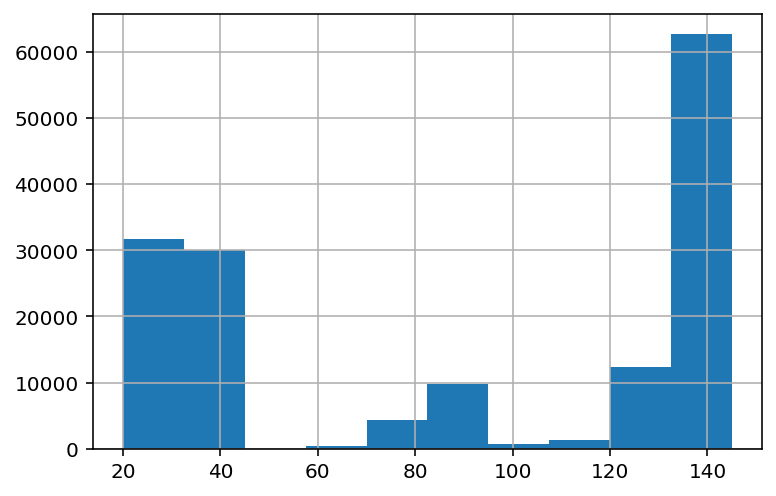

time: 3.19 s (started: 2021-03-27 10:44:41 +00:00)


In [29]:
dataset_raw.swifter.apply(lambda x: x.count(), axis=1).hist();

### Number of available variables per row histogram (final all age groups)

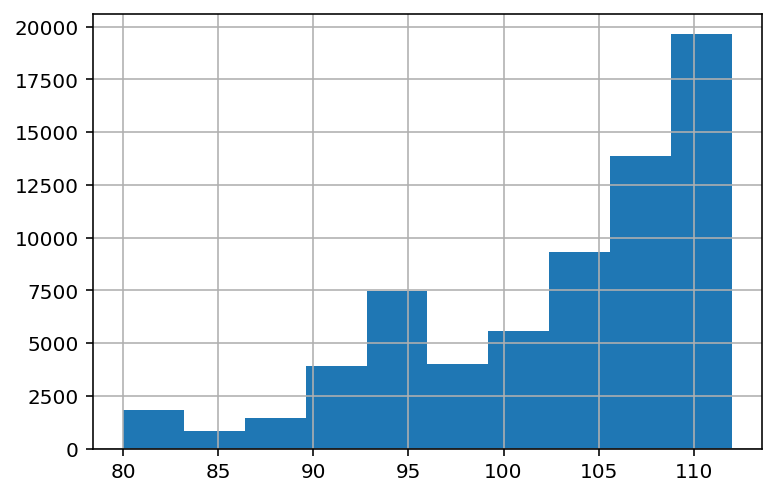

time: 2.22 s (started: 2021-03-27 10:44:44 +00:00)


In [30]:
X_365.swifter.apply(lambda x: x.count(), axis=1).hist();


### Total input features after preprocessing

Note: additional variables might be automatically removed during training due to 0 variance

In [31]:
display_number(len(X_365.columns))

time: 19.9 ms (started: 2021-03-27 10:44:46 +00:00)


## Class balance

### 365 days survival

In [32]:
y_365.value_counts()

0    59545
1     8394
dtype: int64

time: 31.7 ms (started: 2021-03-27 10:44:46 +00:00)


### 90 days survival

In [33]:
y_90.value_counts()

0    65342
1     5501
dtype: int64

time: 34.1 ms (started: 2021-03-27 10:44:46 +00:00)


## Death-year relation


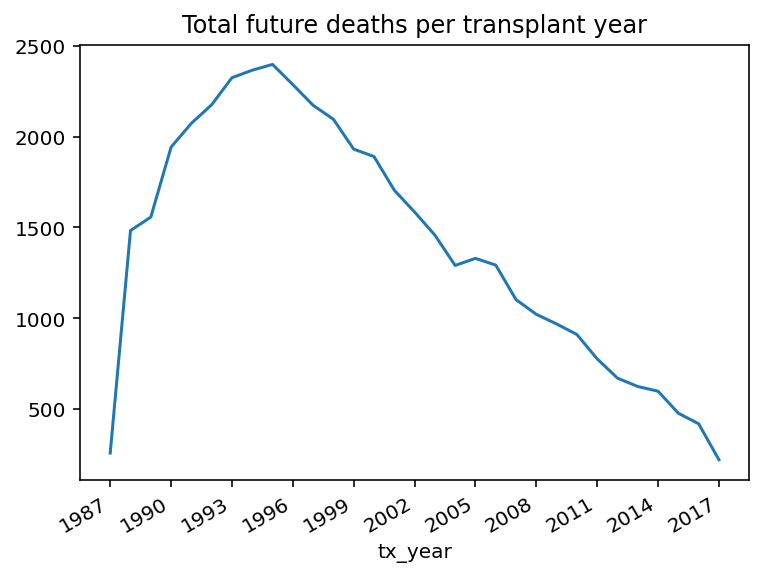

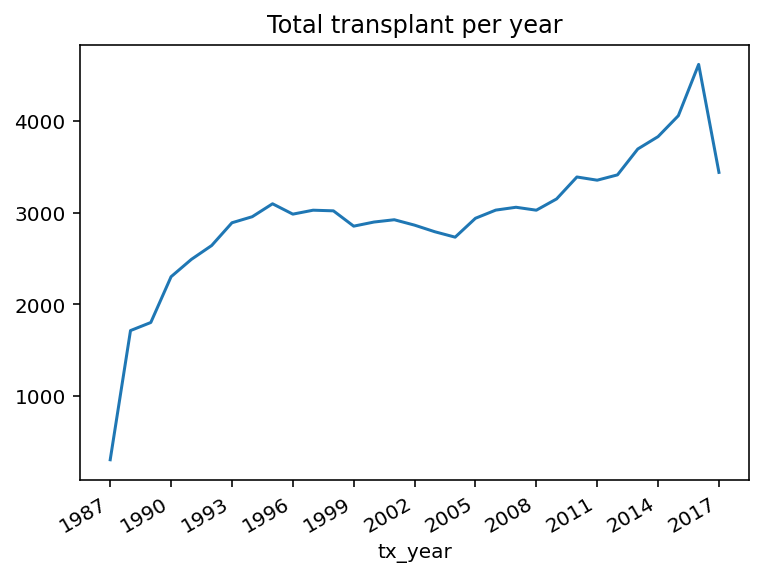

time: 419 ms (started: 2021-03-27 10:44:46 +00:00)


In [34]:
from matplotlib import pyplot

def set_x_ticks():
    plt.xticks([
        *range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
        int(dataset_raw['tx_year'].max())
    ])


pyplot.title('Total future deaths per transplant year')
dataset_raw['death'].groupby(dataset_raw['tx_year']).sum().plot()
pyplot.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
set_x_ticks()
pyplot.show()

pyplot.title('Total transplant per year')
dataset_raw['death'].groupby(dataset_raw['tx_year']).count().plot()
pyplot.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks([*range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
            int(dataset_raw['tx_year'].max())])

pyplot.show()

In [35]:
len(dataset_raw[dataset_raw['tx_year'].isna()])


61862

time: 80.8 ms (started: 2021-03-27 10:44:47 +00:00)


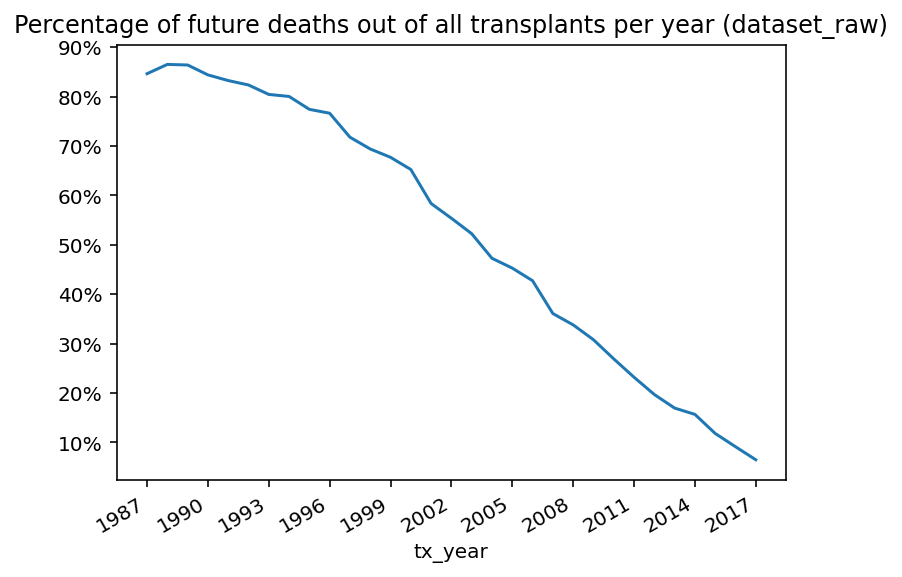

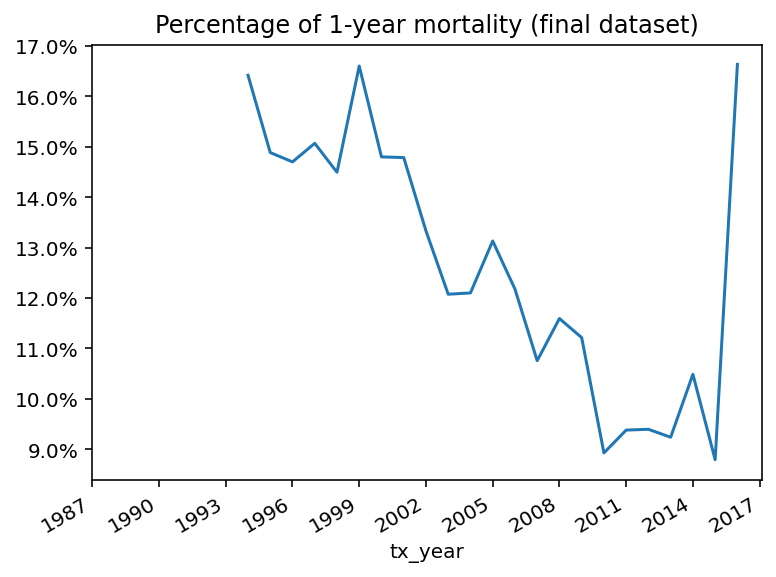

time: 302 ms (started: 2021-03-27 10:44:47 +00:00)


In [36]:
import matplotlib as mpl
from matplotlib import pyplot as plt

grouped = dataset_raw['death'].groupby(dataset_raw['tx_year'])
pyplot.title('Percentage of future deaths out of all transplants per year (dataset_raw)')
(grouped.sum() / grouped.count() * 100).plot()
plt.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks([
    *range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
    int(dataset_raw['tx_year'].max())
])
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
pyplot.show()

grouped = y_365.groupby(dataset_raw['tx_year'])
pyplot.title('Percentage of 1-year mortality (final dataset)')
(grouped.sum() / grouped.count() * 100).plot()
plt.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks([
    *range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
    int(dataset_raw['tx_year'].max())
])
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
pyplot.show()

## Features

> left: input
>
> ⬇
>
> center: preprocessed / omitted
>
> ⬇
>
> right: log / omitted

1. Thoracic diagnosis (thoracic_dgn)


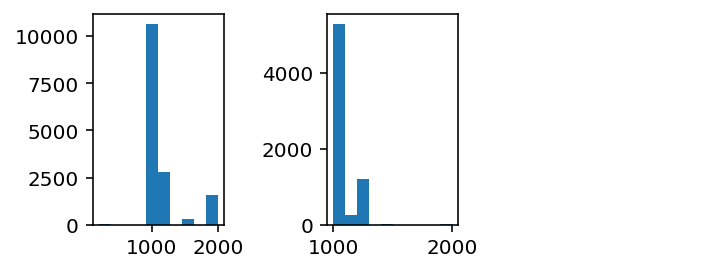

2. Gender (gender)


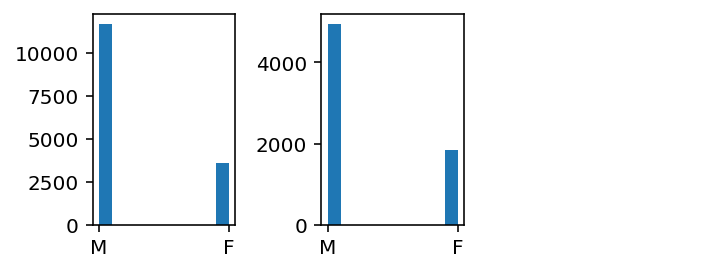

3. Blood group (abo)


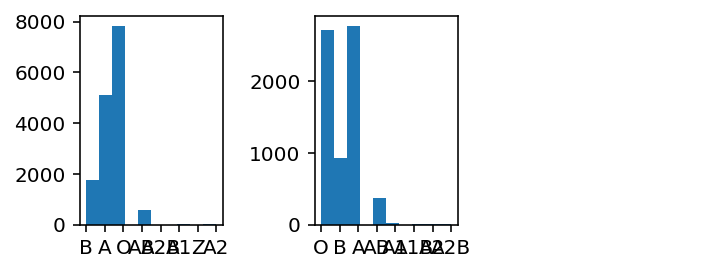

4. Recipient weight (wgt_kg_tcr)


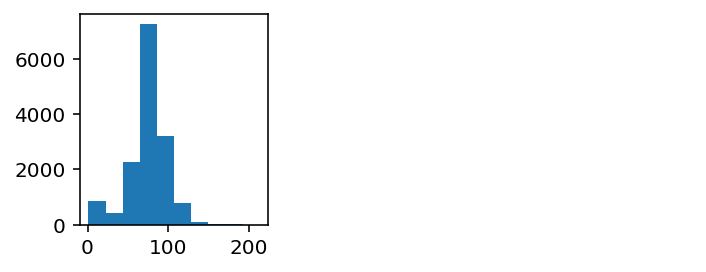

5. hgt_cm_tcr


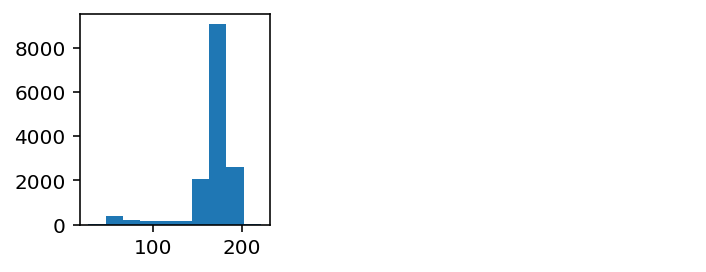

6. Intra-aortic balloon pump (iabp_tcr)


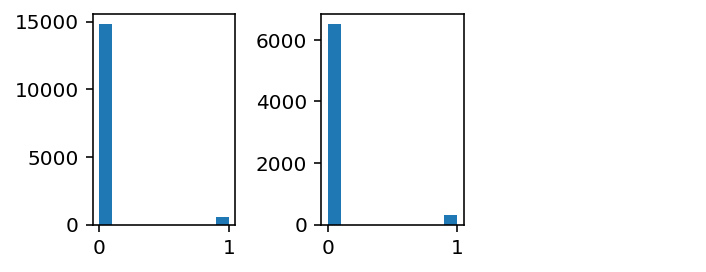

7. Inotropic Support (inotropes_tcr)


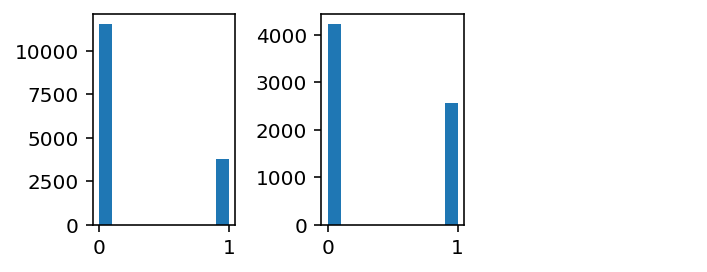

8. Functional status at listing recipient (func_stat_tcr)


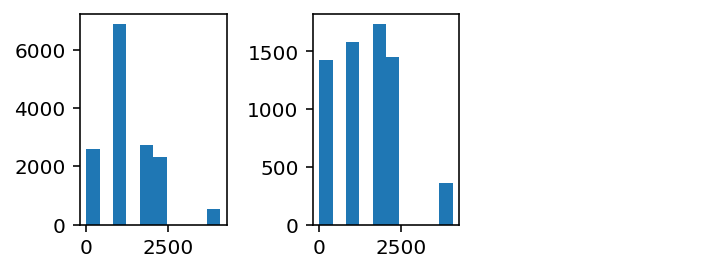

9. Diabetes (diab)


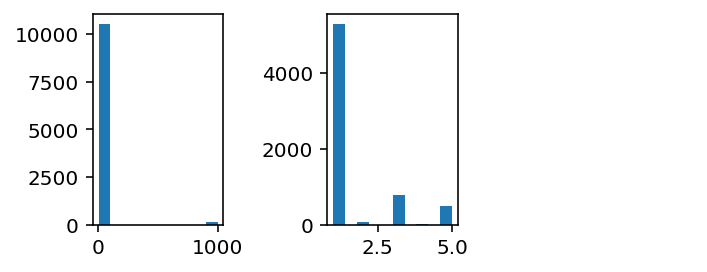

10. Cerebrovascular disease (cereb_vasc)


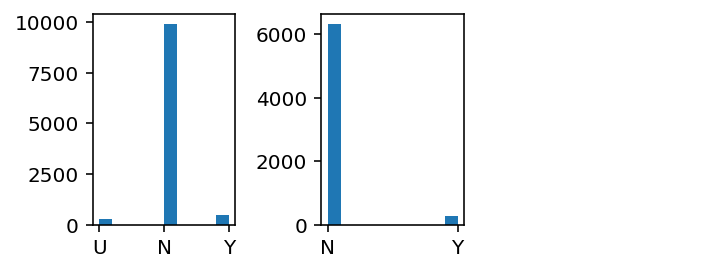

11. Creatinine at listing (log_most_rcnt_creat)


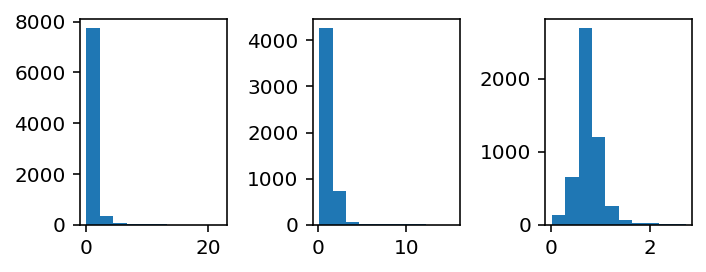

12. Serum albumin (tot_serum_album)


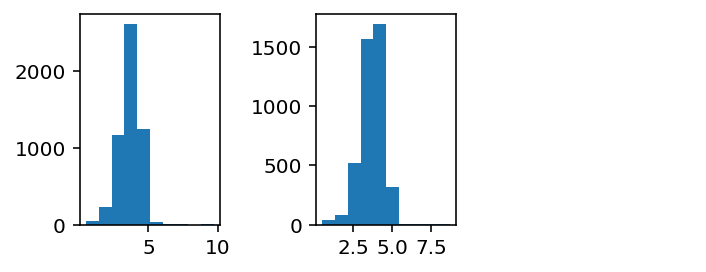

13. sud_death


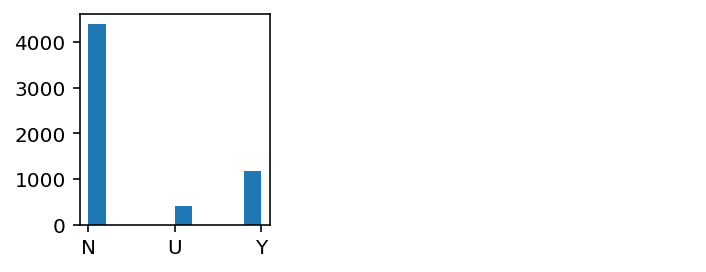

14. Defibrillator in recipient (impl_defibril)


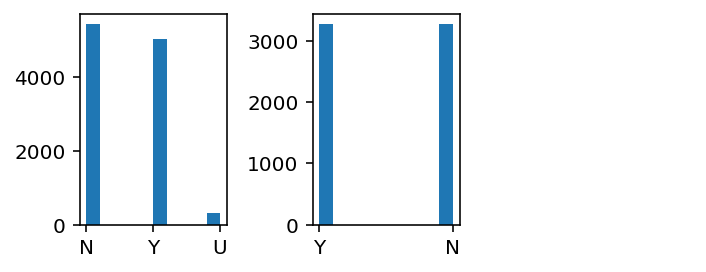

15. Systolic pulmonary pressure recipient (mmHg) (hemo_sys_tcr)


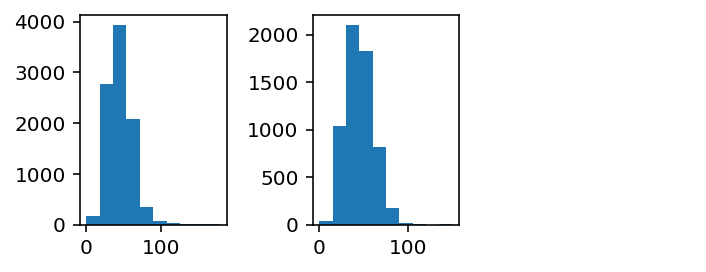

16. Diastolic pulmonary pressure recipient (mmHg) (hemo_pa_dia_tcr)


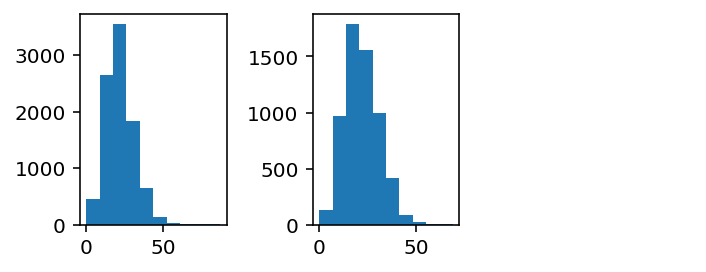

17. Mean pulmonary pressure recipient (mmHg) (hemo_pa_mn_tcr)


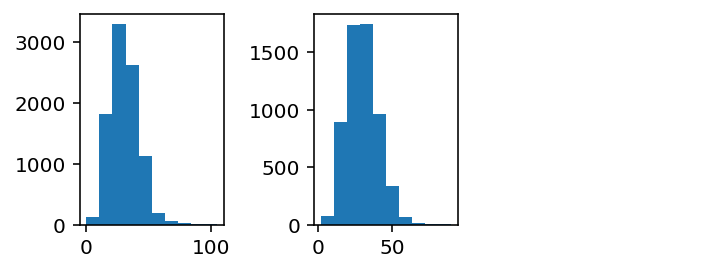

18. Mean pulmonary wedge pressure recipient (mmHg) (hemo_pcw_tcr)


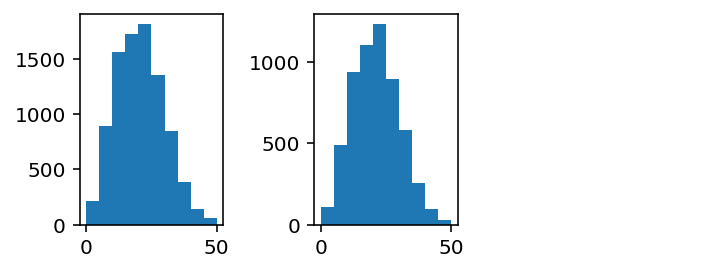

19. Cardiac output recipient (L/min) (hemo_co_tcr)


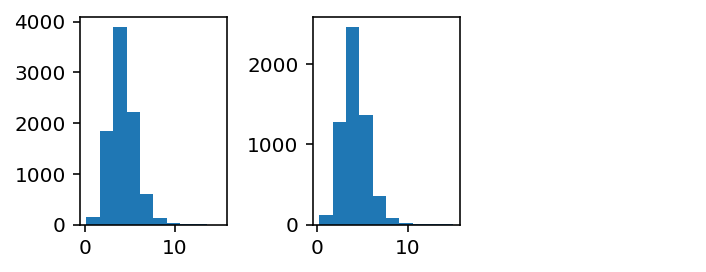

20. Cigarette use recipient (cig_use)


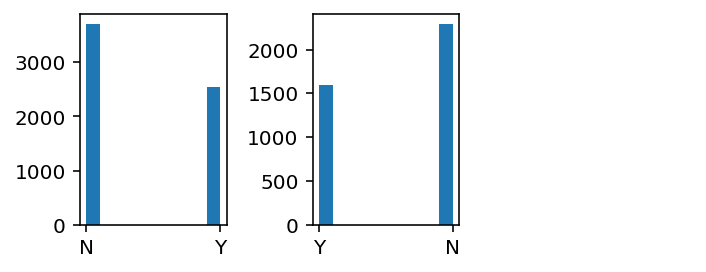

21. Prior cardiac surgery recipient (prior_card_surg_tcr)


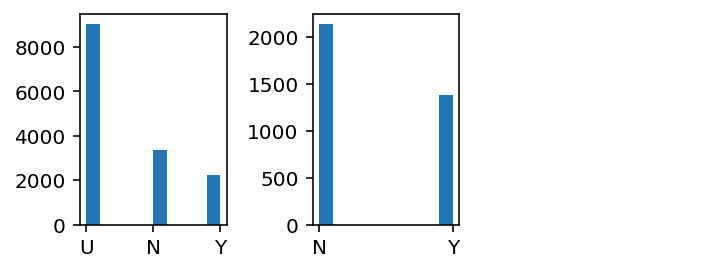

22. Prior cardiac surgery recipient type (prior_card_surg_type_tcr)


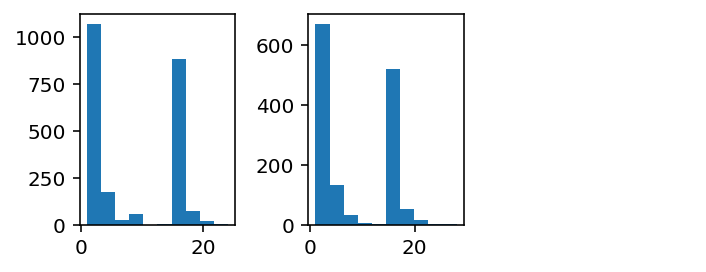

23. Ethnicity (ethcat)


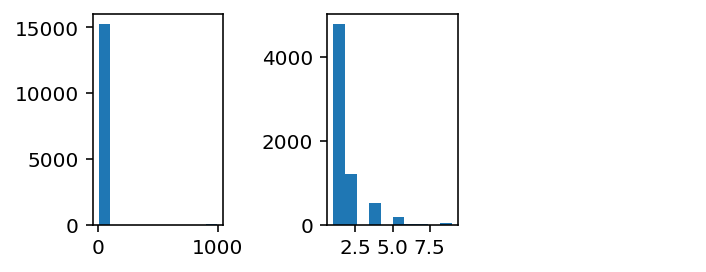

24. Ventilator Support at Listing (ventilator_tcr)


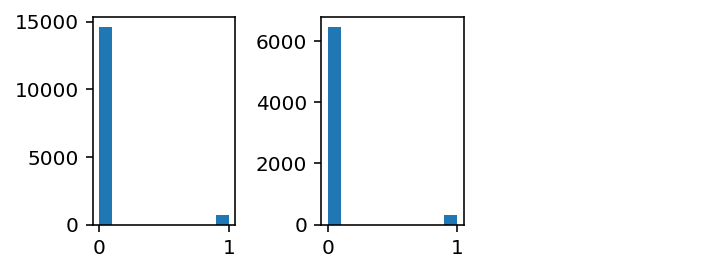

25. LV assist device (lvad ever)


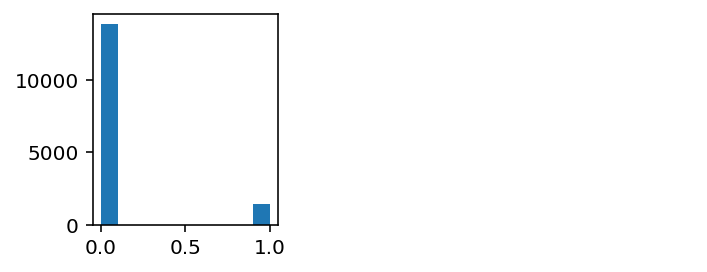

26. RV assist device (rvad ever)


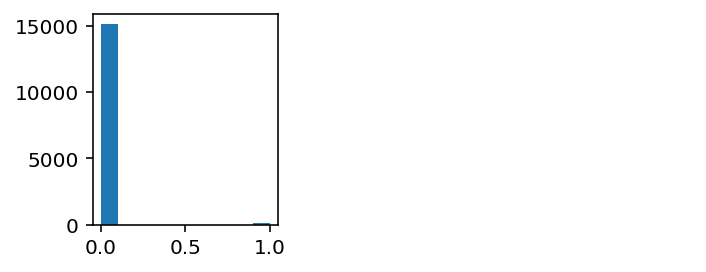

27. Total artificial heart (tah ever)


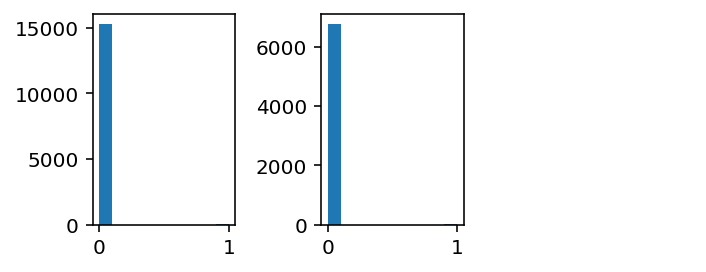

28. func_stat_trr


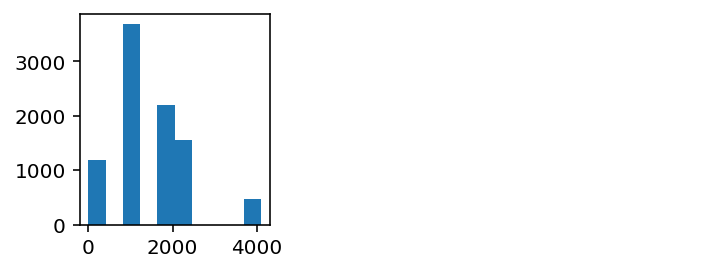

29. Medical condition at transplant (med_cond_trr)


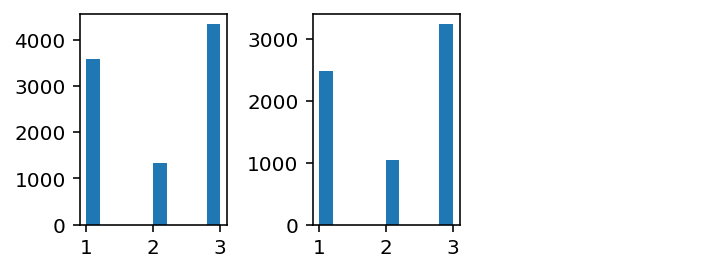

30. ECMO at Transplant (ecmo_trr)


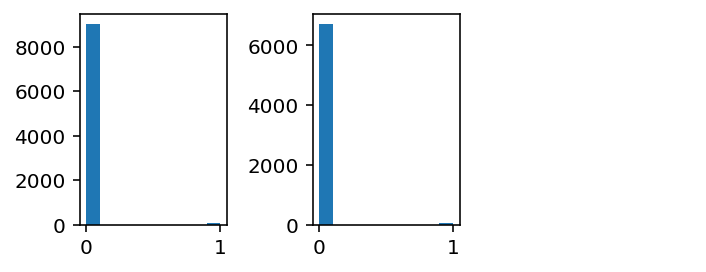

31. Creatinine at transplant (log_creat_trr)


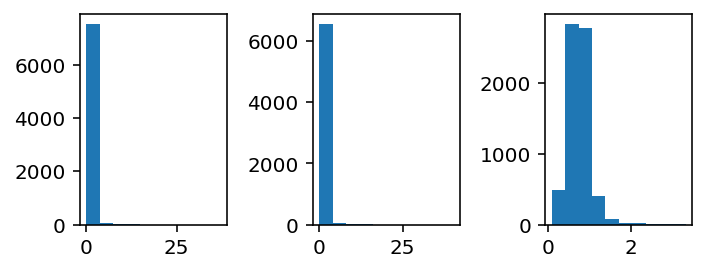

32. Dialysis after listing (dial_after_list)


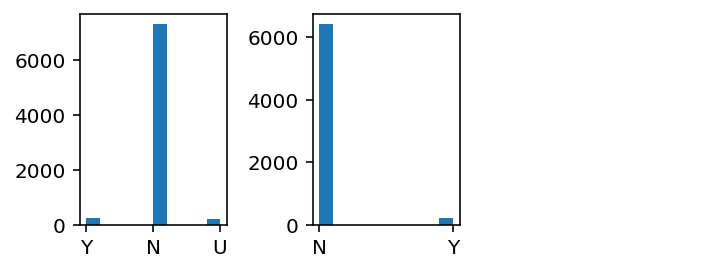

33. Bilirubin—Recipient (log_tbili)


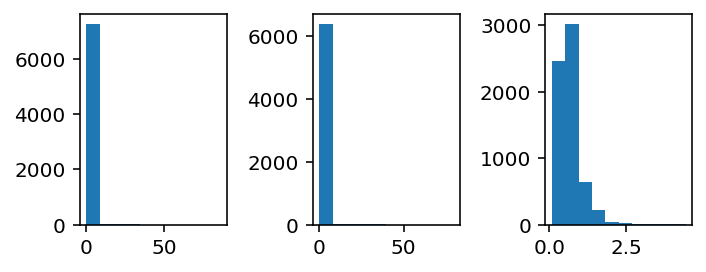

34. Transfusions since listing (transfusions)


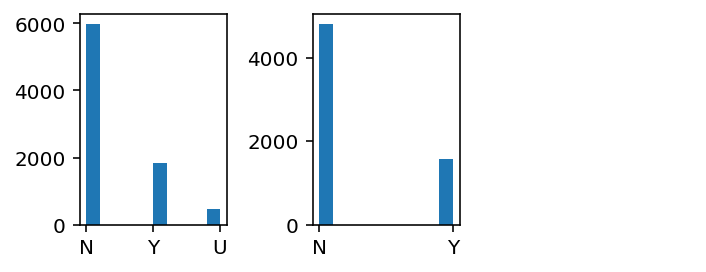

35. HBV core (hbv_core)


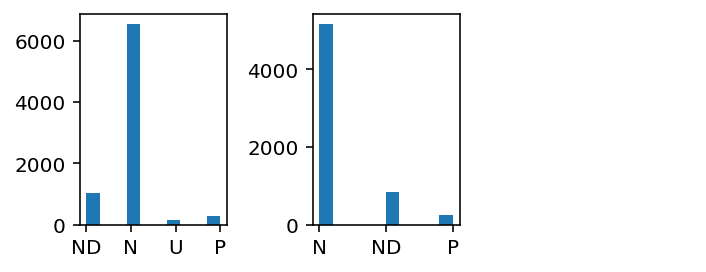

36. HBV surface antigen (hbv_sur_antigen)


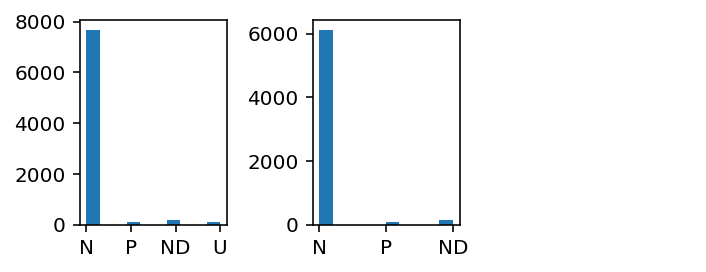

37. CMV status (cmv_status)


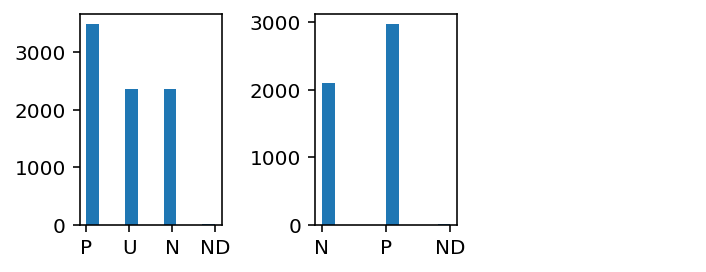

38. HIV serostatus (hiv_serostatus)


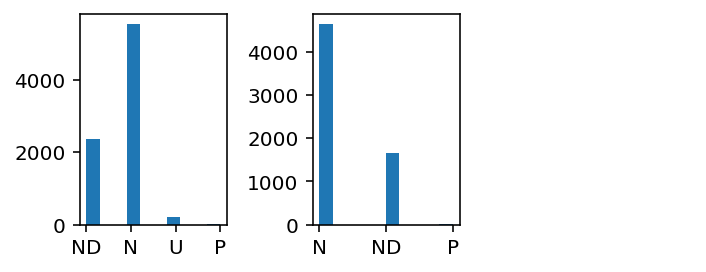

39. HCV serostatus (hcv_serostatus)


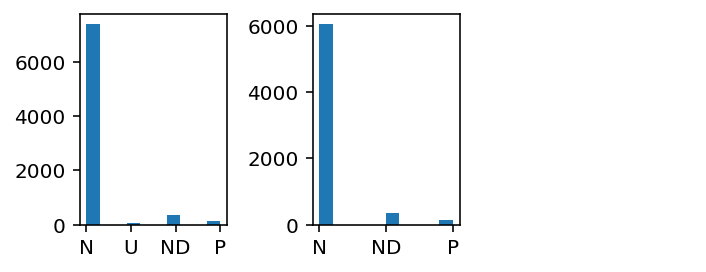

40. EBV serostatus (ebv_serostatus)


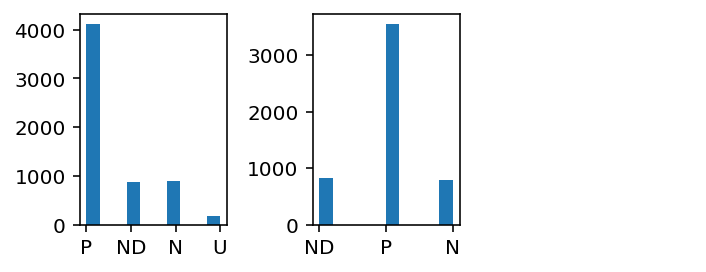

41. Survival of graft (gstatus)


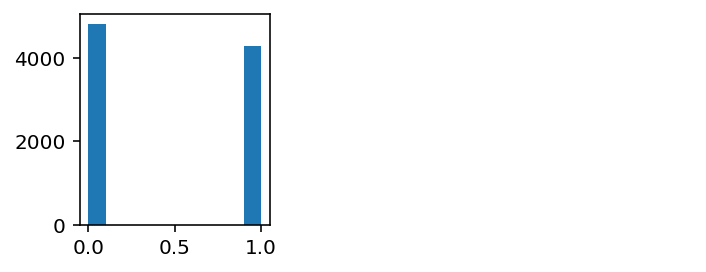

42. Time of graft survival (gtime)


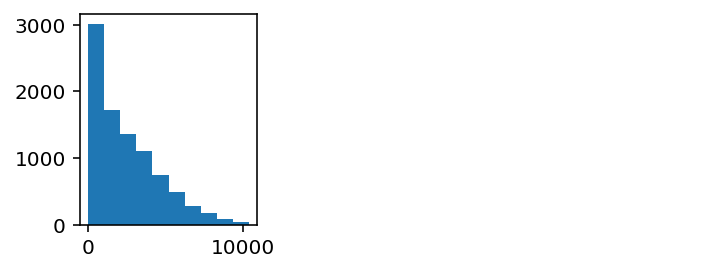

43. Patient survival (pstatus)


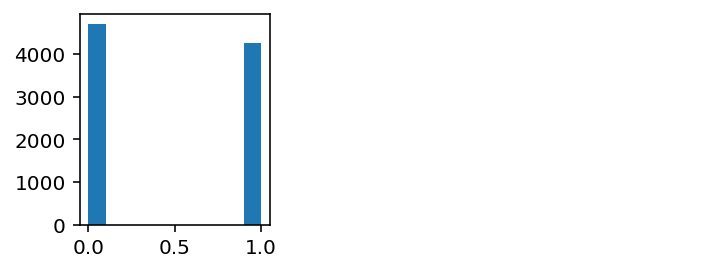

44. Time of patient survival (ptime)


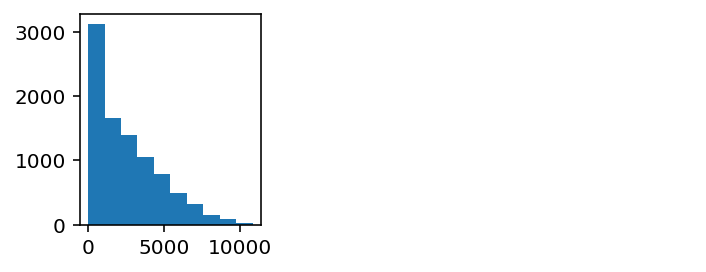

45. Patient status (px_stat)


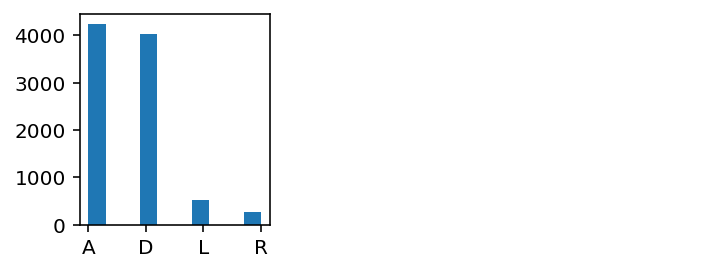

46. Previous transplantation (prev_tx)


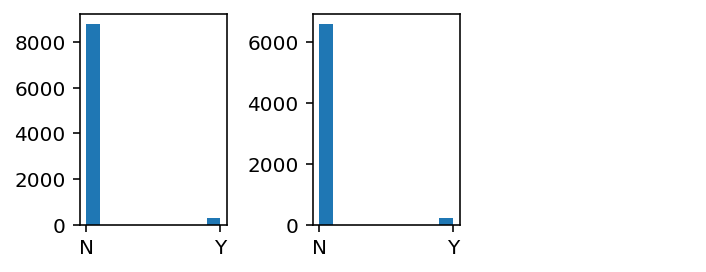

47. Previous transplantation (prev_tx_any)


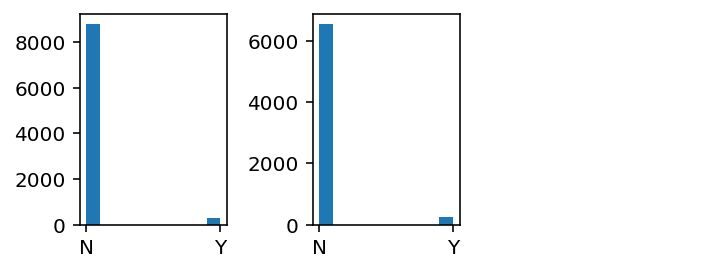

48. CMV IgG (cmv_igg)


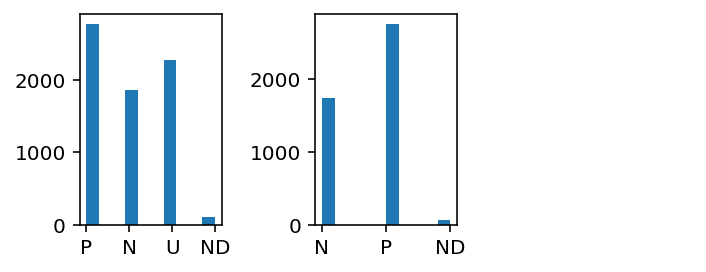

49. CMV IgM (cmv_igm)


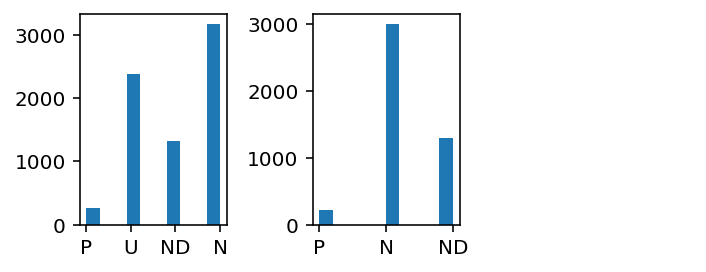

50. History of cocaine use—Donor (hist_cocaine_don)


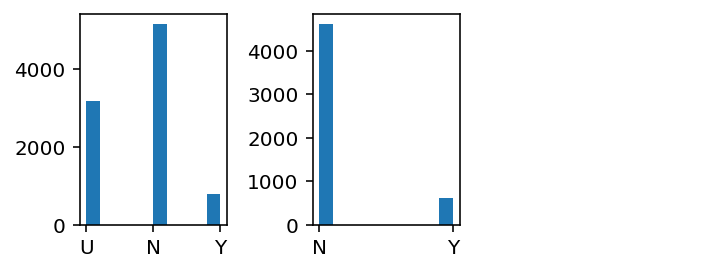

51. Age donor (log_age_don)


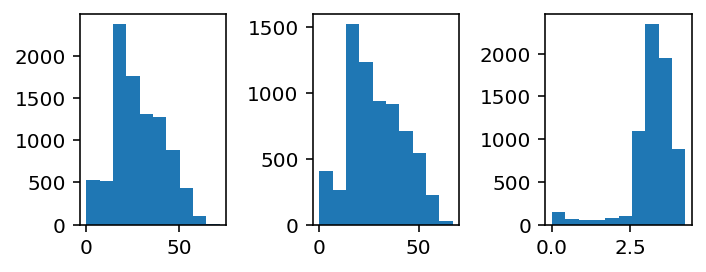

52. Ethnicity donor (ethcat_don)


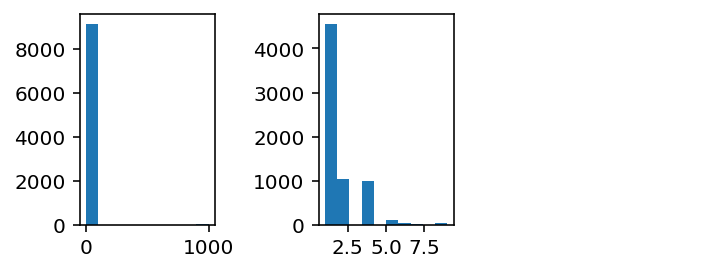

53. HBV core donor (hbv_core_don)


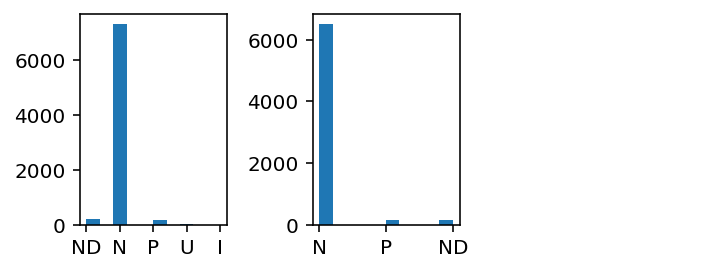

54. HBV surface antigen donor (hbv_sur_antigen_don)


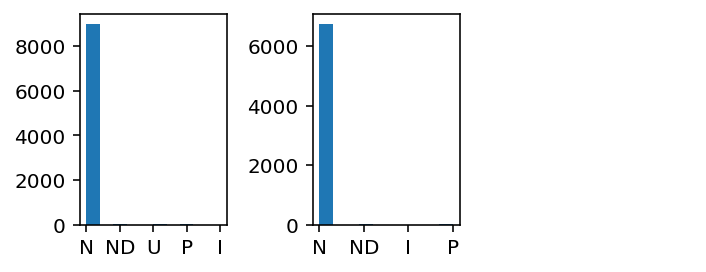

55. Blood group donor (abo_don)


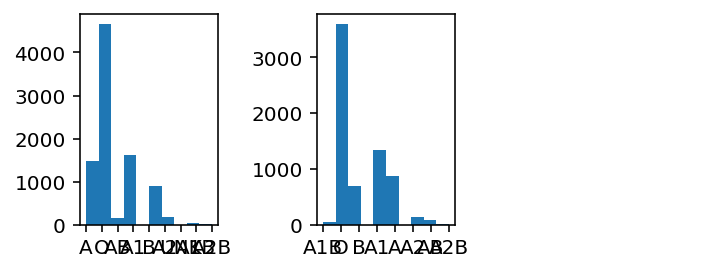

56. Heavy alcohol use donor (alcohol_heavy_don)


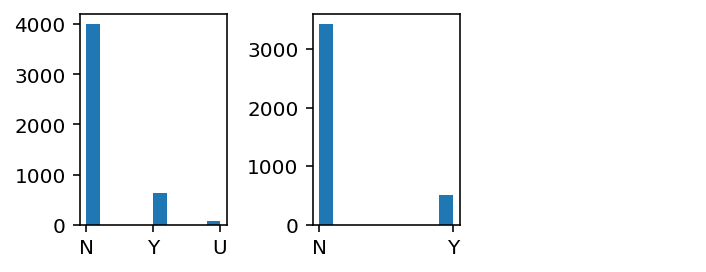

57. Gender donor (gender_don)


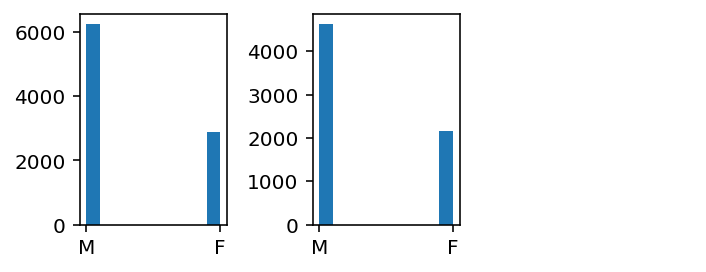

58. HCV serostatus donor (hep_c_anti_don)


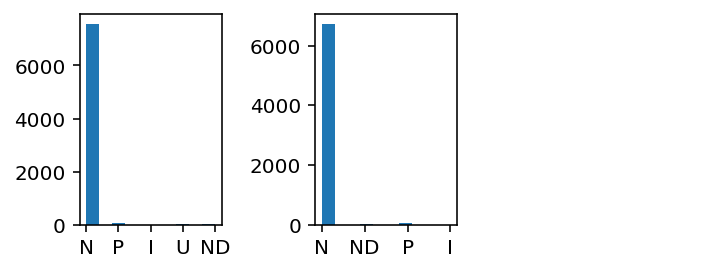

59. Non-beating heart donor (non_hrt_don)


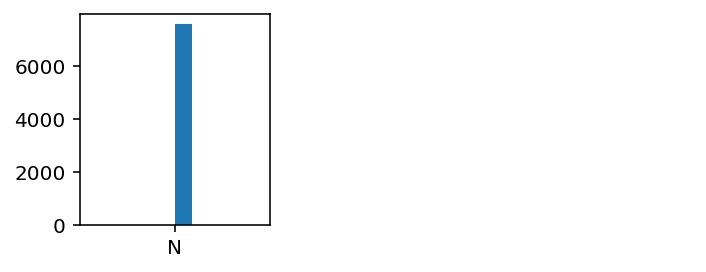

60. Infection in blood Donor (blood_inf_don)


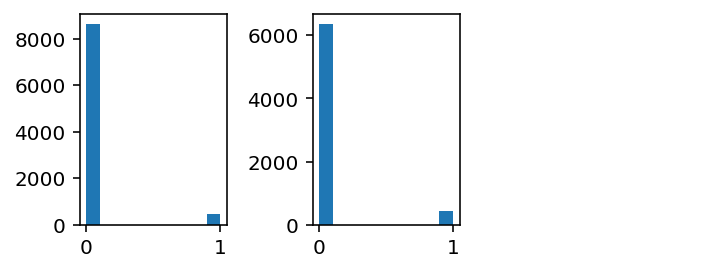

61. Blood urea nitrogen donor (log_bun_don)


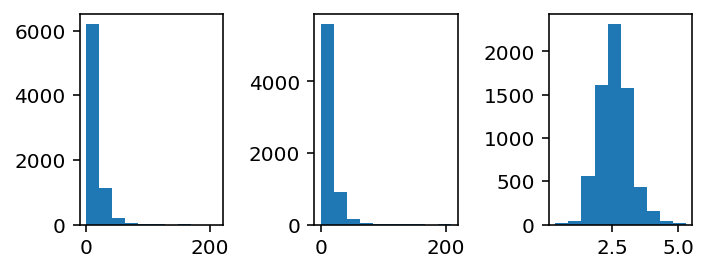

62. Creatinine donor (log_creat_don)


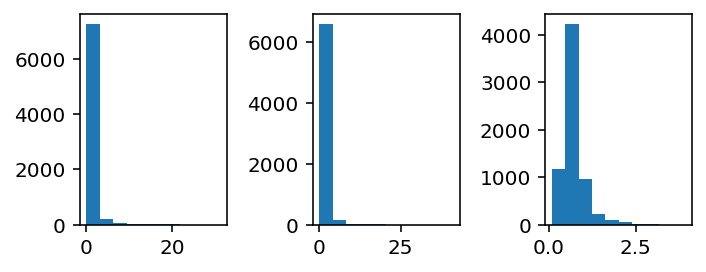

63. Other infection in donor (other_inf_don)


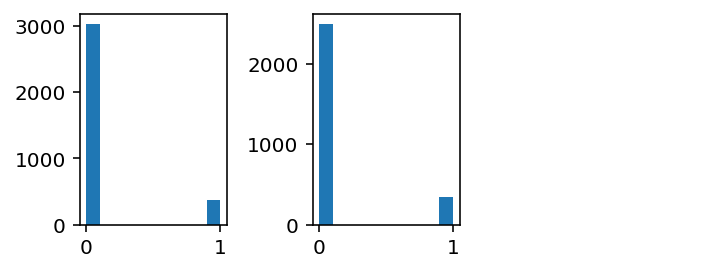

64. Pulmonary infection donor (pulm_inf_don)


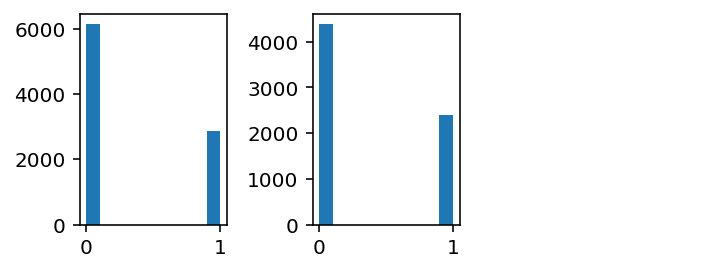

65. AST donor (log_sgot_don)


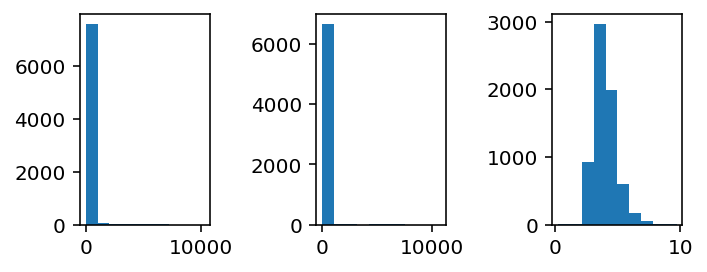

66. ALT donor (log_sgpt_don)


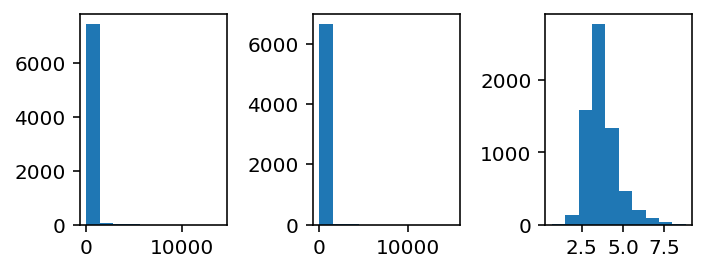

67. Bilirubin—Donor (log_tbili_don)


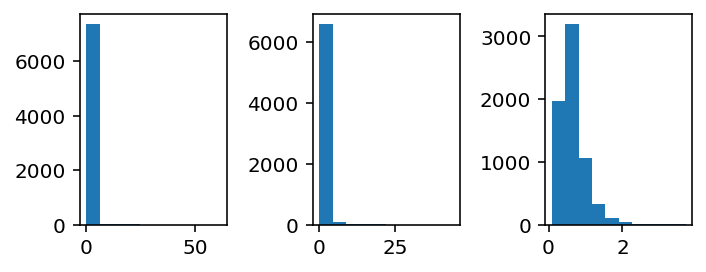

68. Urine infection donor (urine_inf_don)


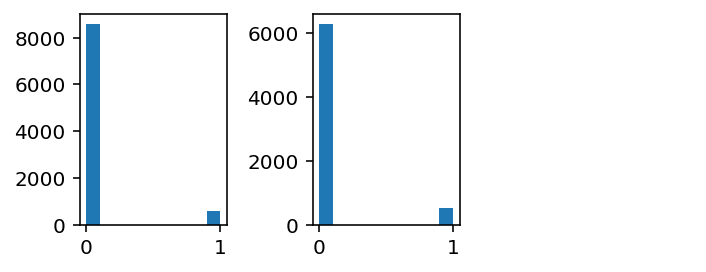

69. Vasodilatators use donor (vasodil_don)


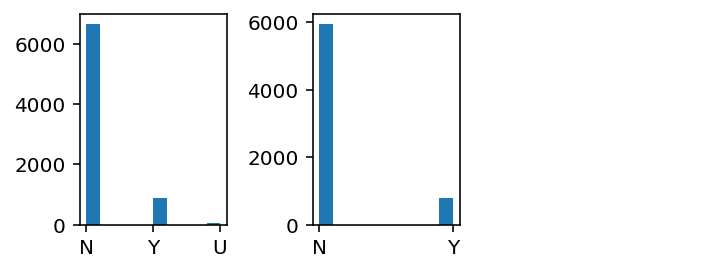

70. RPR-VDRL serology donor (vdrl_don)


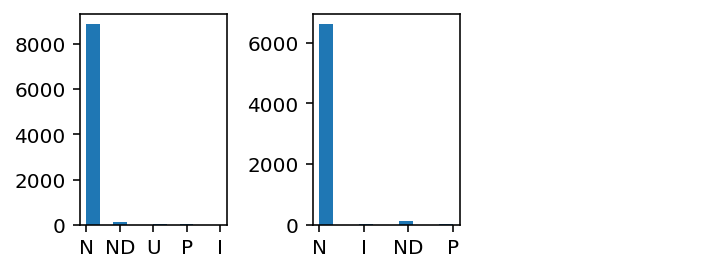

71. Clinical infection donor (clin_infect_don)


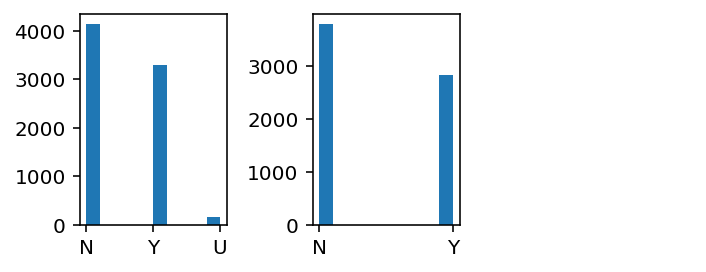

72. Cocaine use in last 6 months donor (contin_cocaine_don)


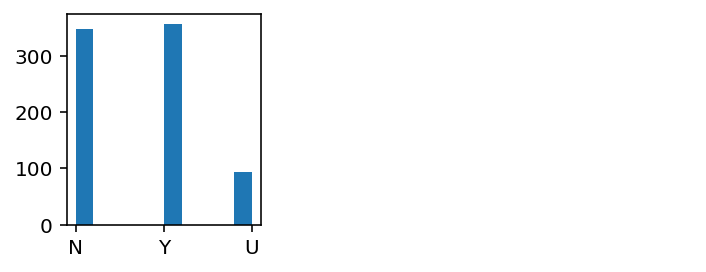

73. Other drug use in last 6 months—Donor (contin_oth_drug_don)


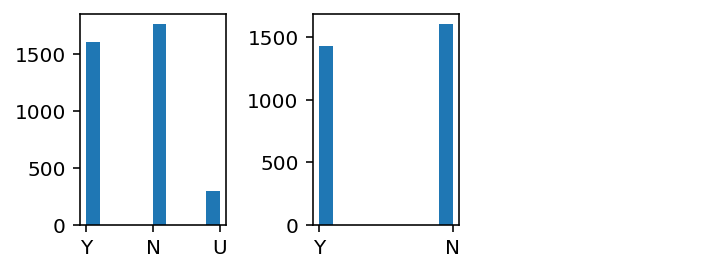

74. Extracranial cancer in donor (extracranial_cancer_don)


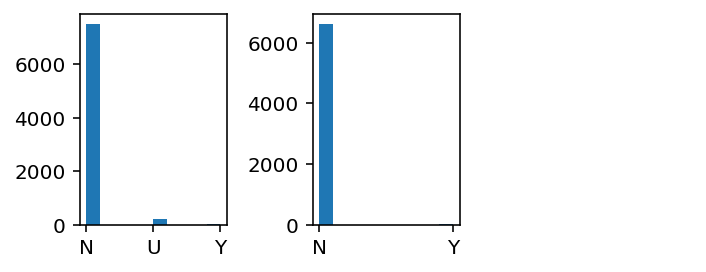

75. History of alcohol in donor (hist_alcohol_old_don)


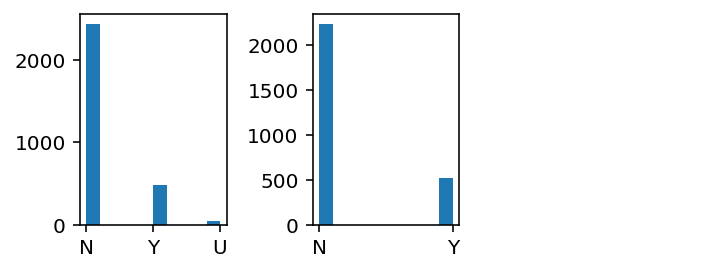

76. Site of cancer donor (cancer_site_don)


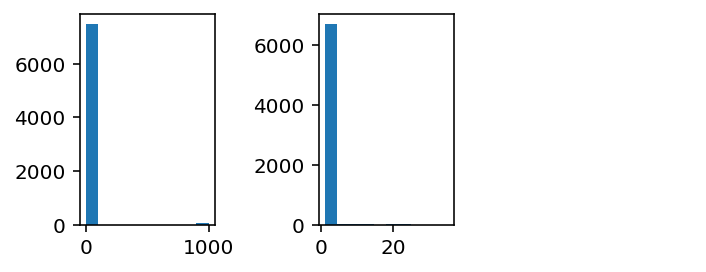

77. History of cigarettes use donor (hist_cig_don)


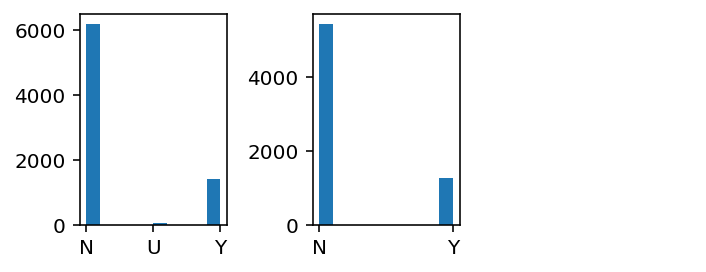

78. History of hypertension donor (hist_hypertens_don)


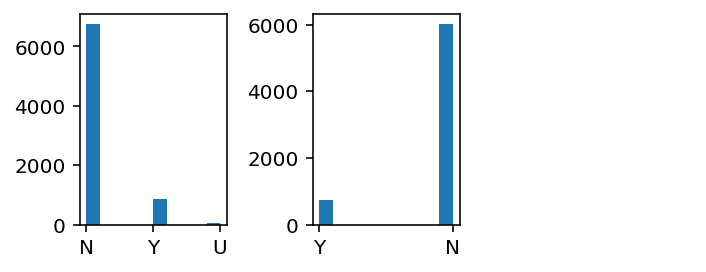

79. History of IV drug use donor (hist_iv_drug_old_don)


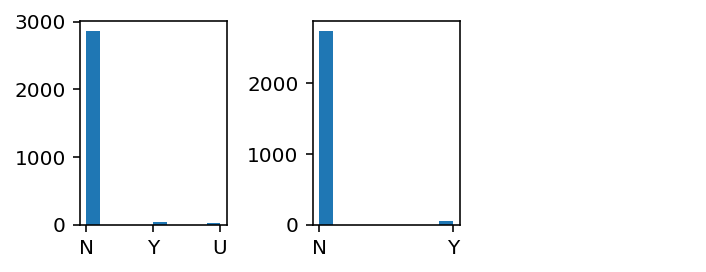

80. Intracranial cancer donor (intracranial_cancer_don)


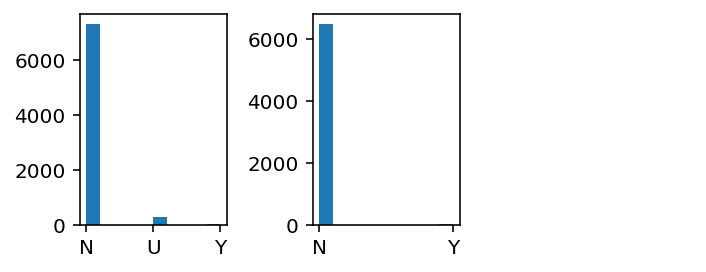

81. History of cancer donor (hist_cancer_don)


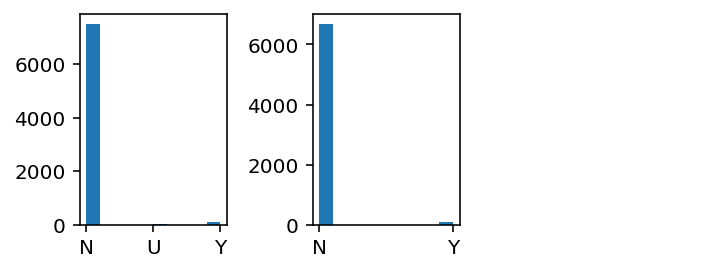

82. Insulin dependence donor (donor insulin)


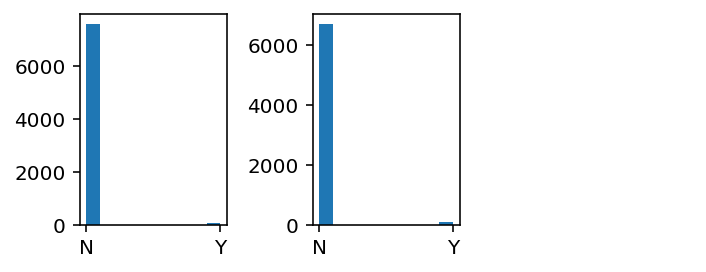

83. Diabetes donor (diabetes_don)


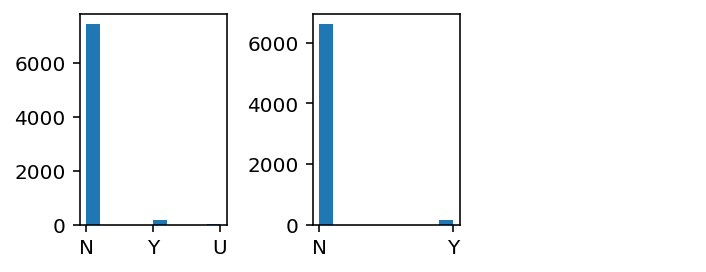

84. History of other drug abuse donor (hist_oth_drug_don)


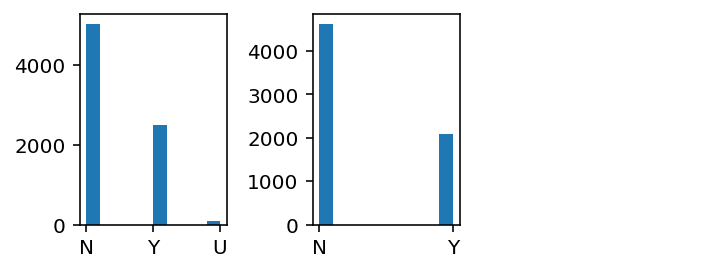

85. Skin cancer in donor (skin_cancer_don)


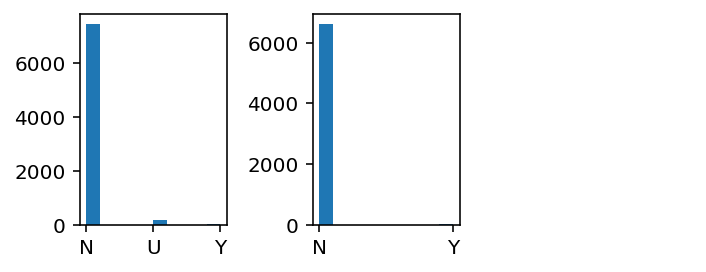

86. CMV infection donor (cmv_don)


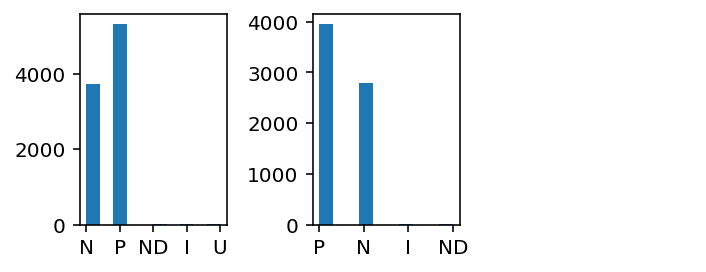

87. Cause of death donor (cod_cad_don)


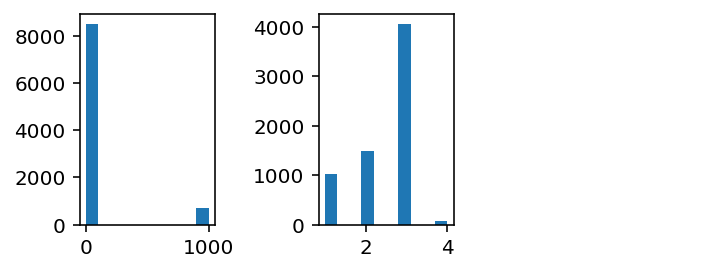

88. Cause of mechanical death donor (death_mech_don)


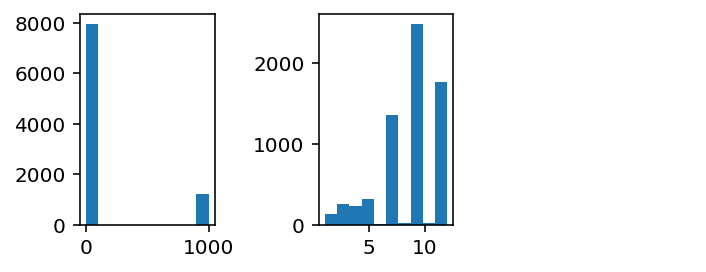

89. Donor height (log_hgt_cm_don_calc)


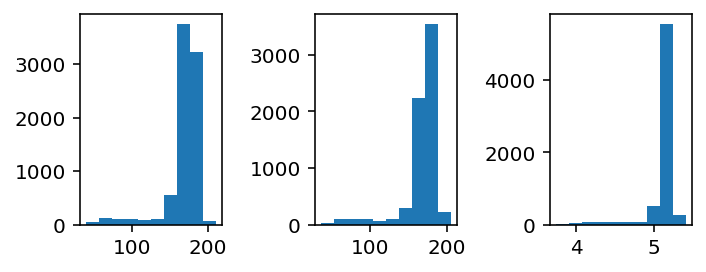

90. Donor weight (log_wgt_kg_don_calc)


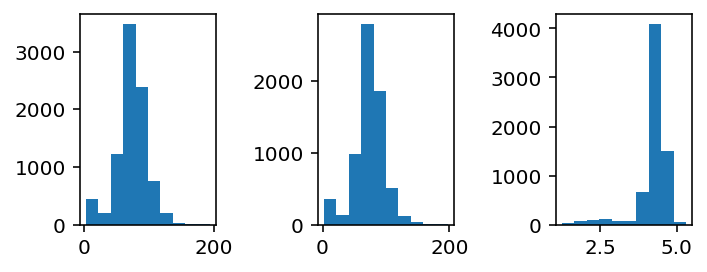

91. Calculated BMI donor (bmi_don_calc)


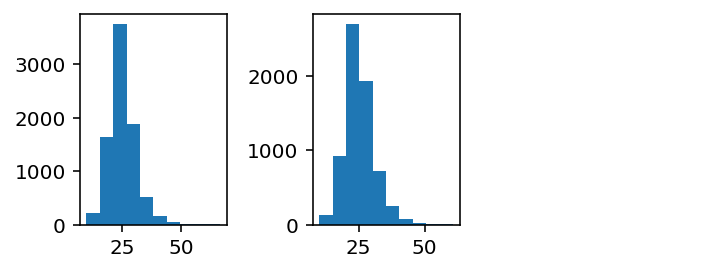

92. Multiorgan transplant (multiorg)


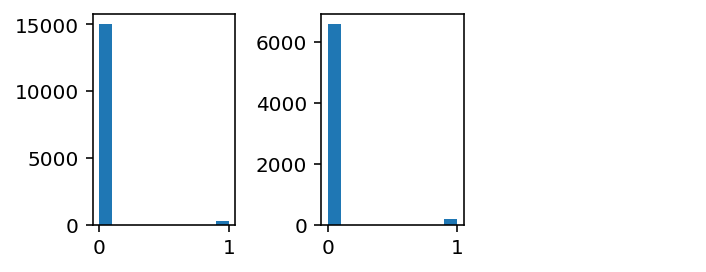

93. Matched bloodgroup (abo_mat)


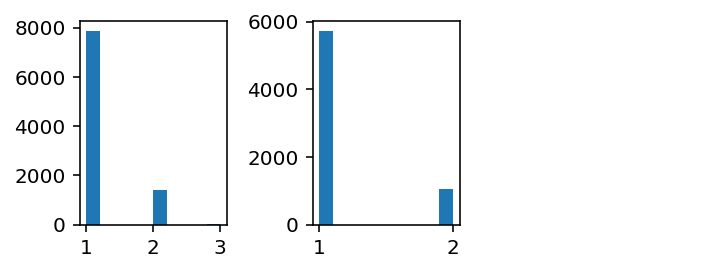

94. Age—Recipient (log_age)


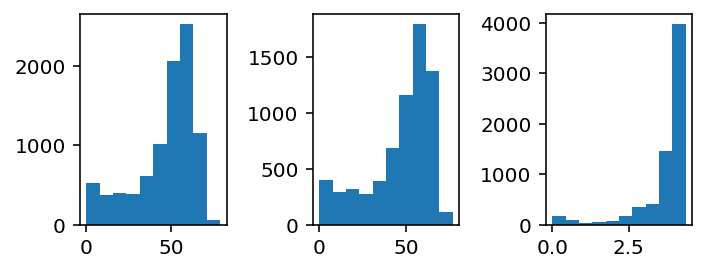

95. Thoracic diagnosis recipient (diag)


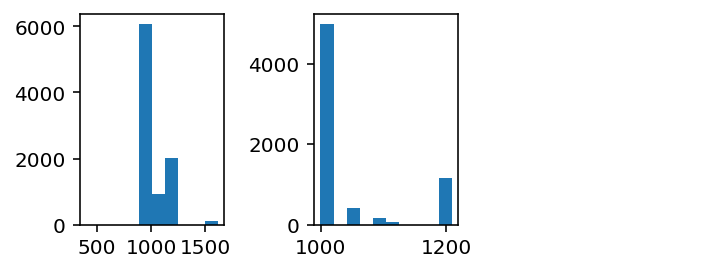

96. Dialysis prior to transplantation (dial_prior_tx)


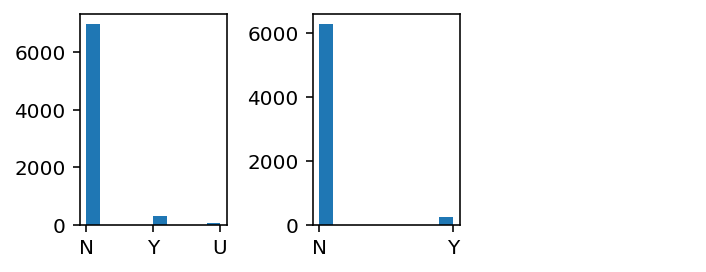

97. Ischemic time (log_ischtime)


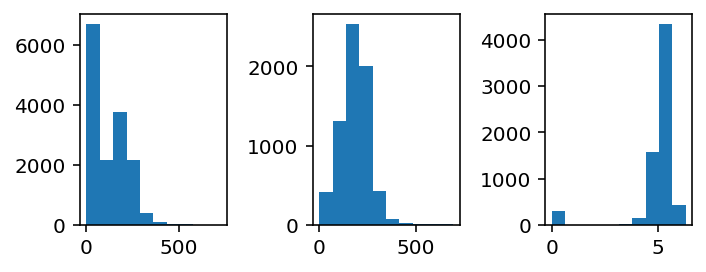

98. Patient on life support—Recipient (life_sup_trr)


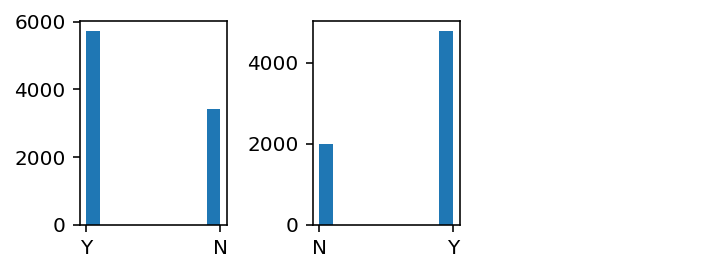

99. Organ Transplanted (organ)


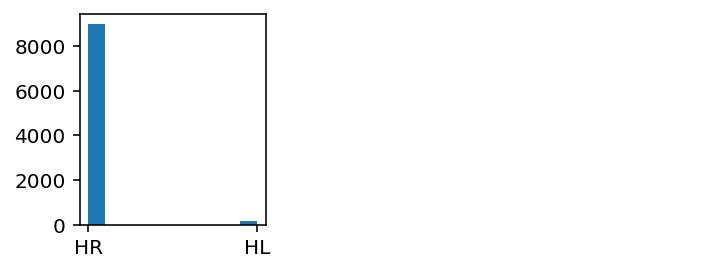

100. Cardiac surgery between listing and transplant (prior_card_surg_trr)


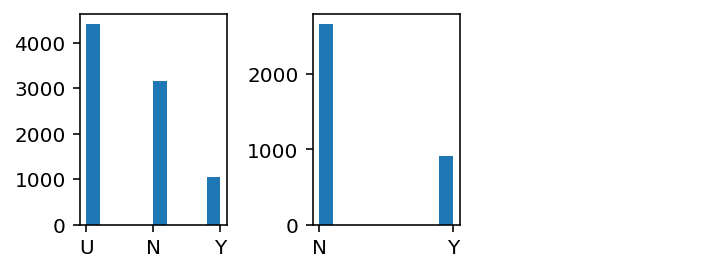

101. Any previous cancer (malig)


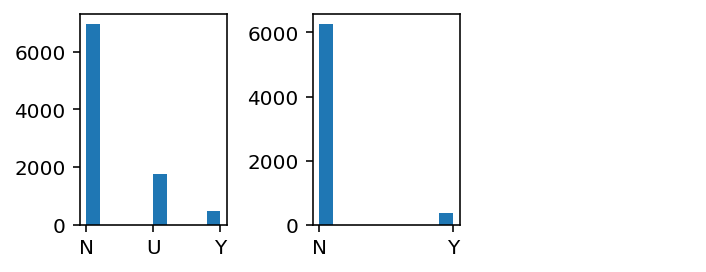

102. Recipient height (log_hgt_cm_calc)


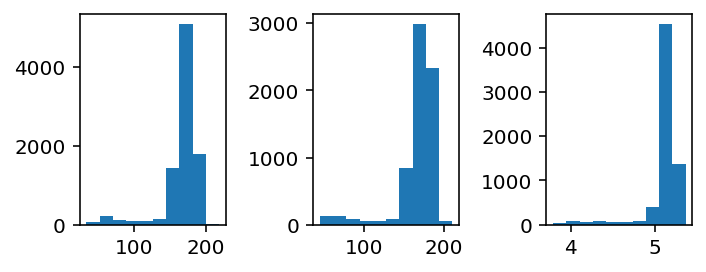

103. Recipient weight (log_wgt_kg_calc)


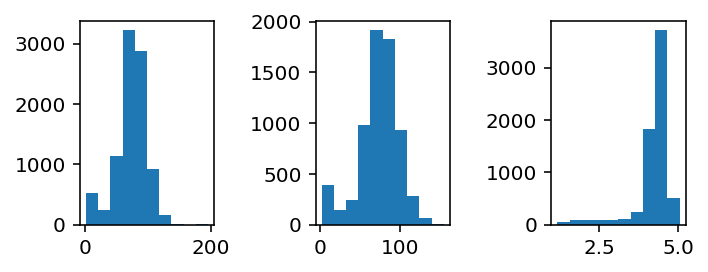

104. BMI recipient (bmi_calc)


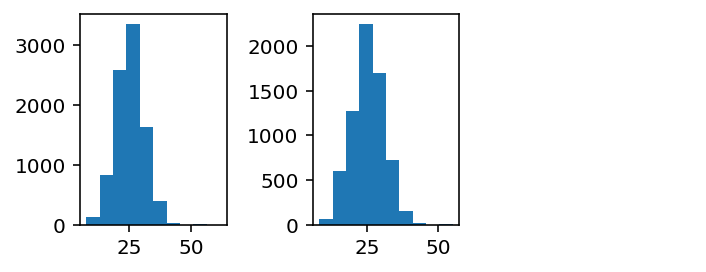

105. Distance between donor and recipient center (log_distance)


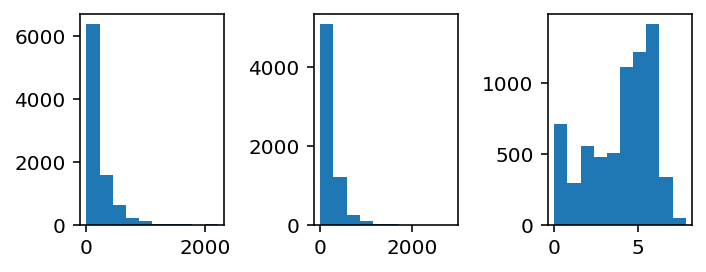

106. Ventilation support after listing (vent_support_after_list)


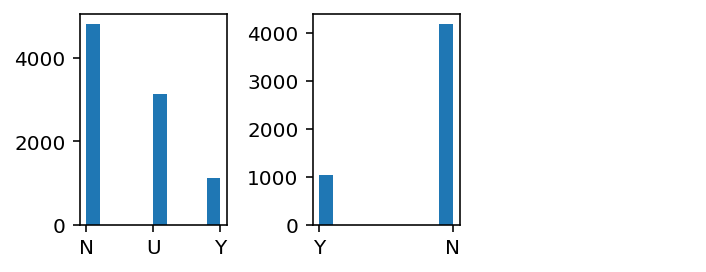

107. Proteinuria (protein_urine)


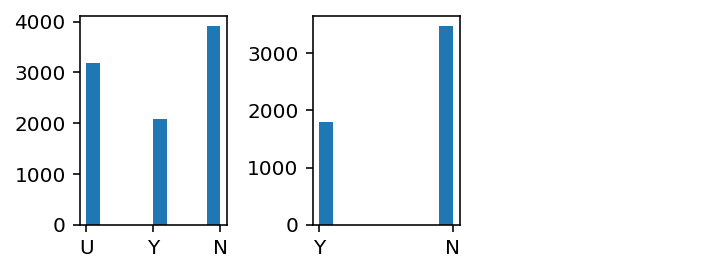

108. History of myocardial infarct (hist_mi)


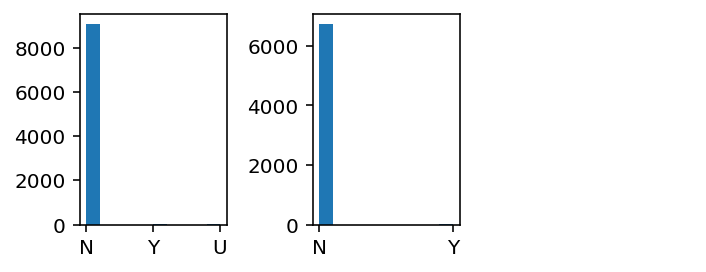

109. Method measuring LVEF donor (lv_eject_meth)


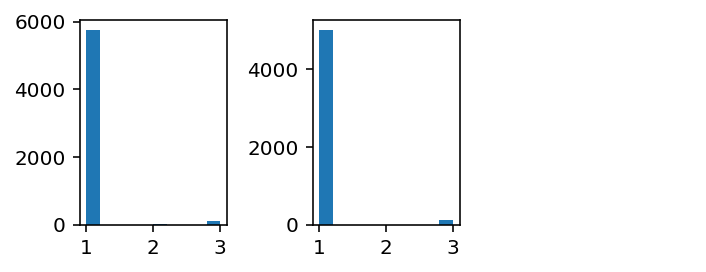

110. LVEF donor (lv_eject)


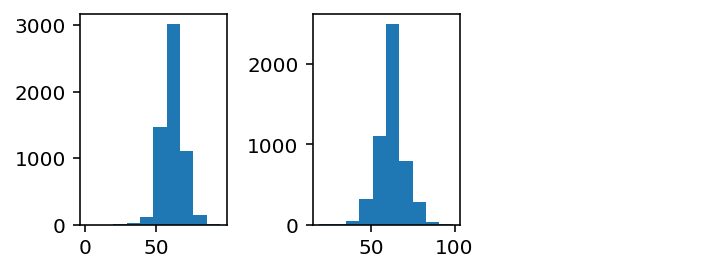

111. Angiogram in donor (coronary_angio)


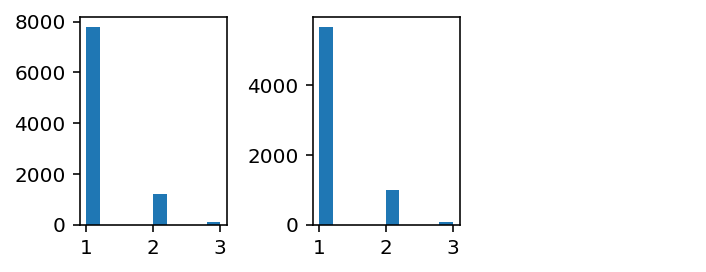

112. Number of vessels with 50% stenosis in donor (vessels_50sten)


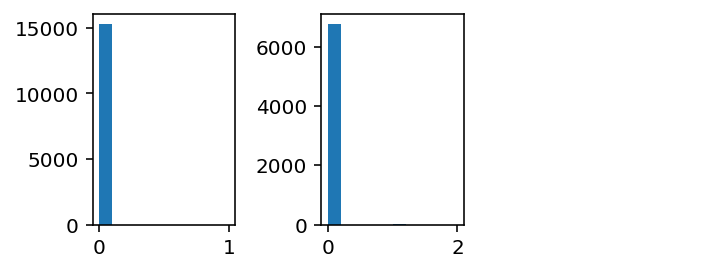

113. Heart biopsy performed donor (biopsy_dgn)


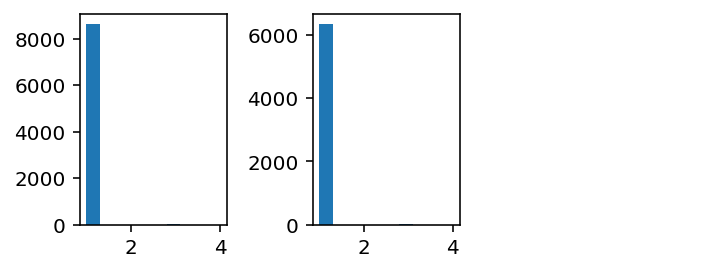

114. Tattoos donor (tattoos)


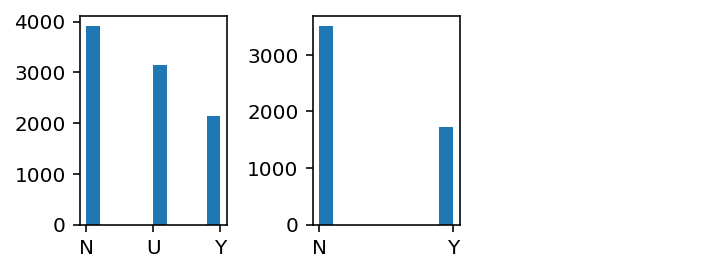

115. EBV IgG in donor (ebv_igg_cad_don)


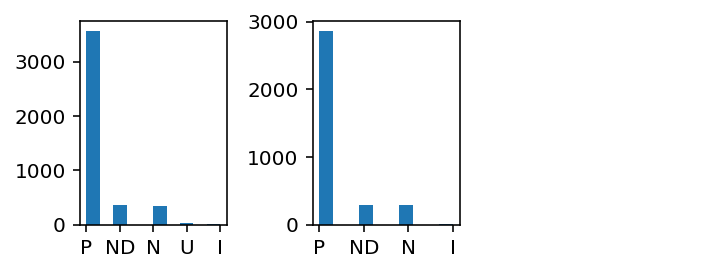

116. CDC high-risk donor (cdc_risk_hiv_don)


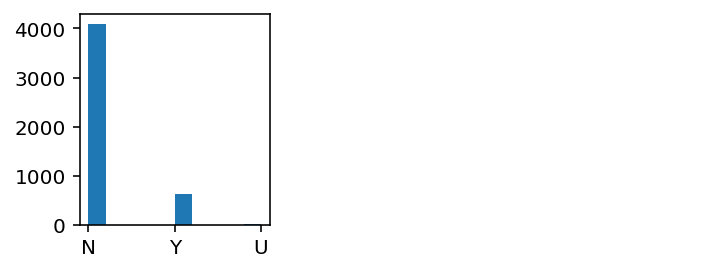

117. Expanded criteria donor (ecd_donor)


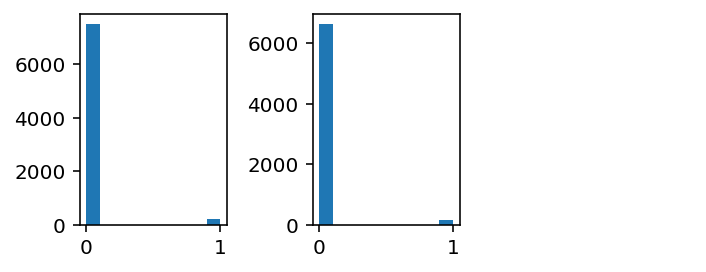

118. Transplant year (tx_year)


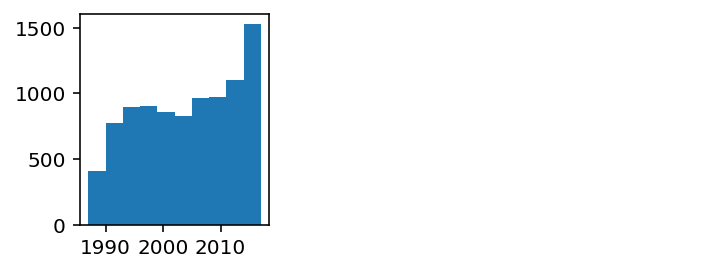

119. Hematocrit donor (hematocrit_don)


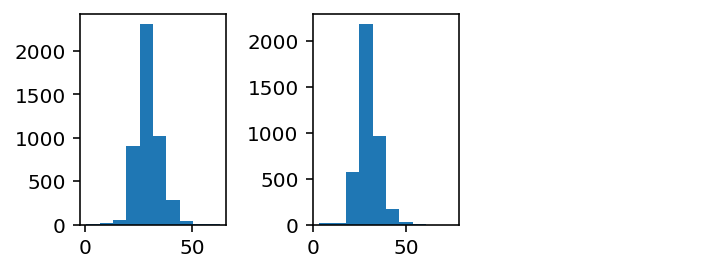

120. Retransplant indiciation (retransplant)


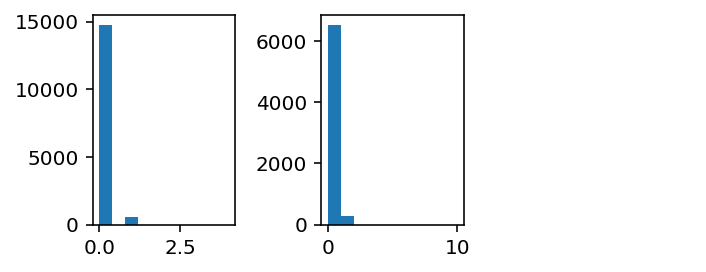

121. Combined panel-reactive antibody (log_newpra)


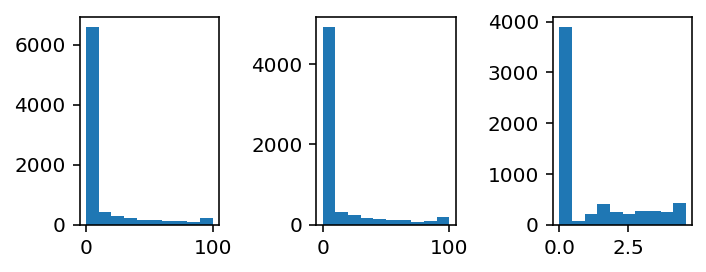

122. Education (education)


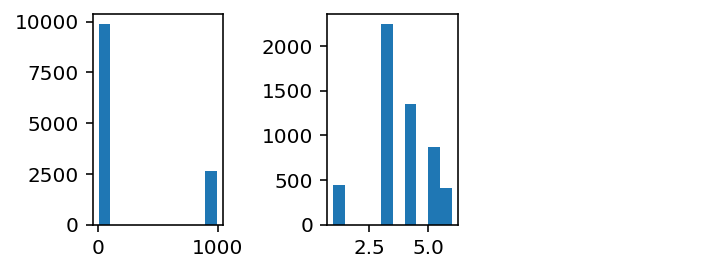

123. Patient died (death)


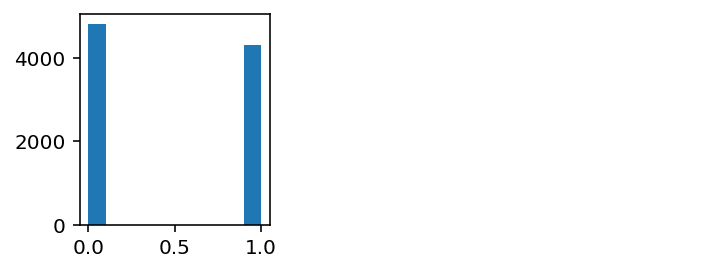

124. Graft status (deathr)


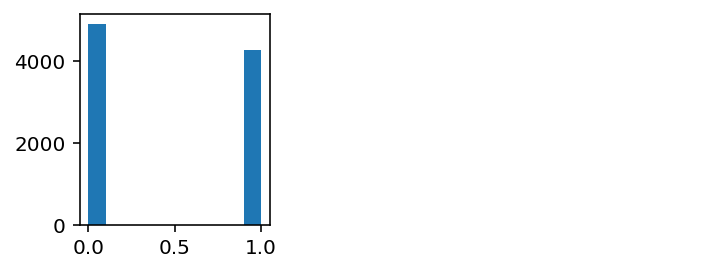

125. Follow up time in days (futd)


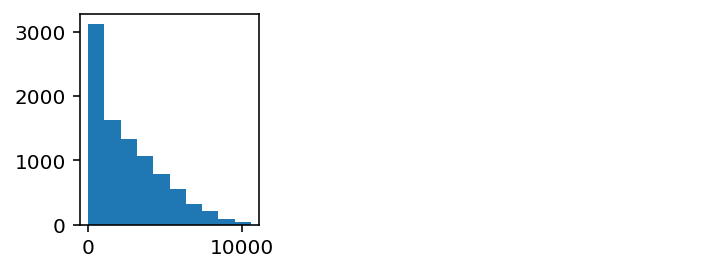

126. futdy


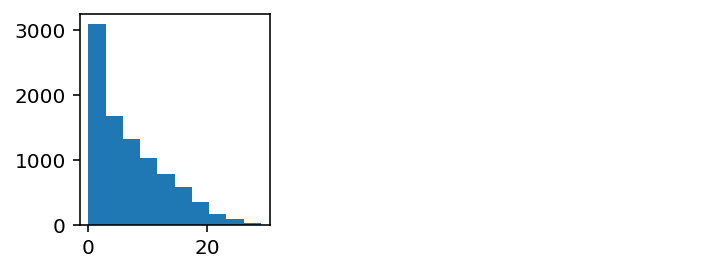

127. Height ratio (height ratio)


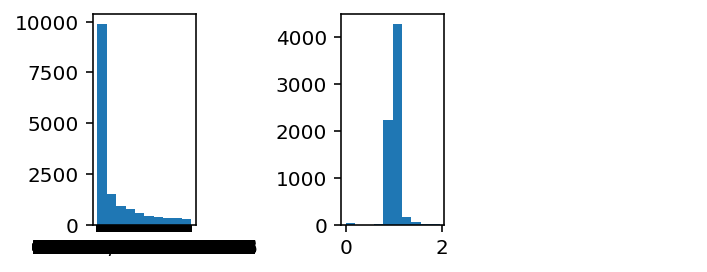

'<=' not supported between instances of 'float' and 'str'
128. Weight ratio (weight ratio)


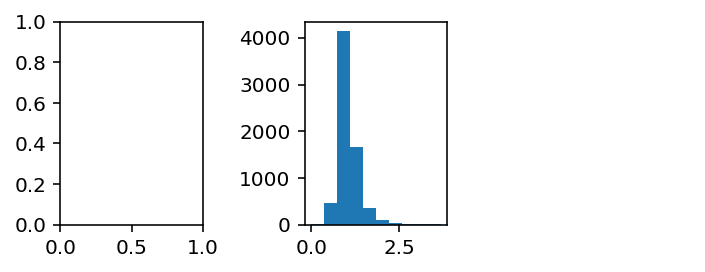

129. rhmass


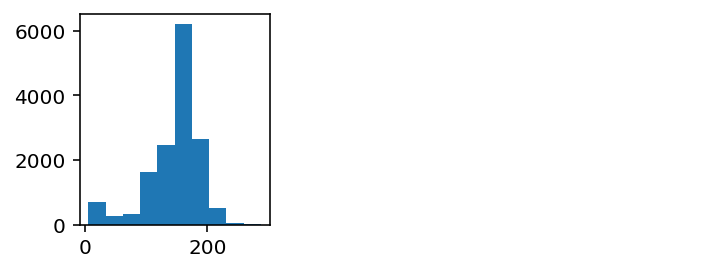

130. dhmass


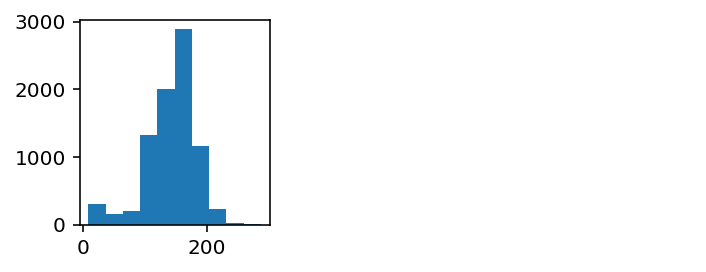

131. hmratio


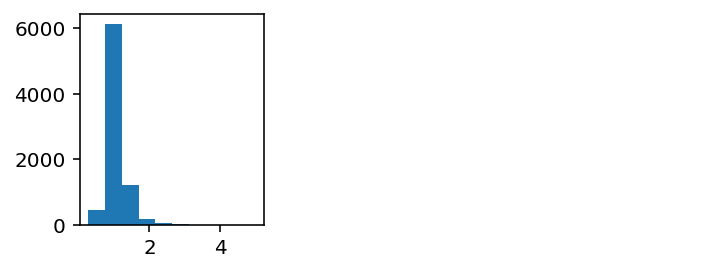

132. newdmass


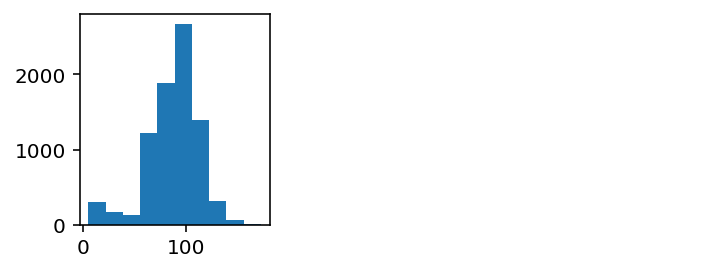

133. newrmass


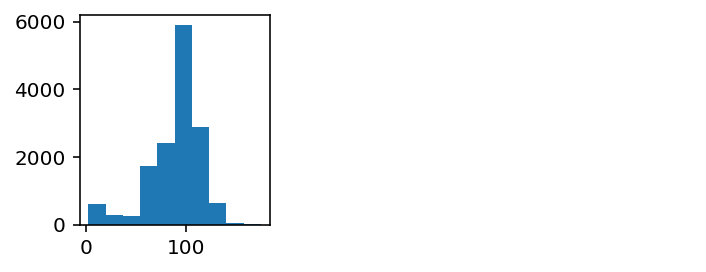

134. newhmratio


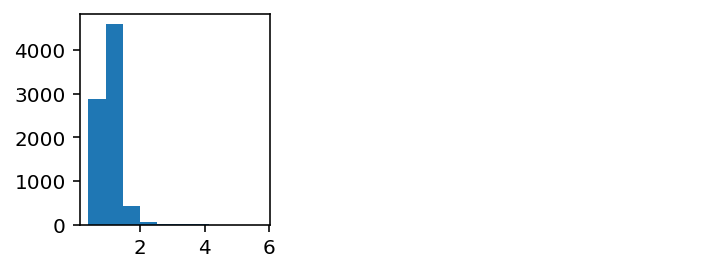

135. Congenital heart disease indication (congenital)


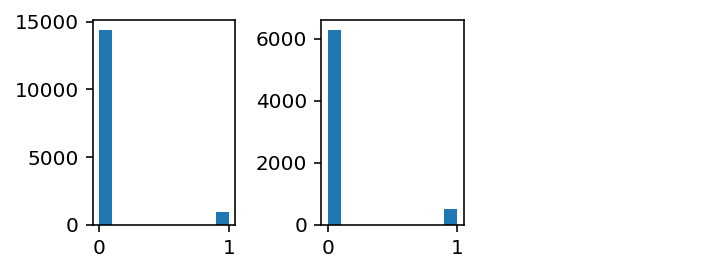

136. newdlbm


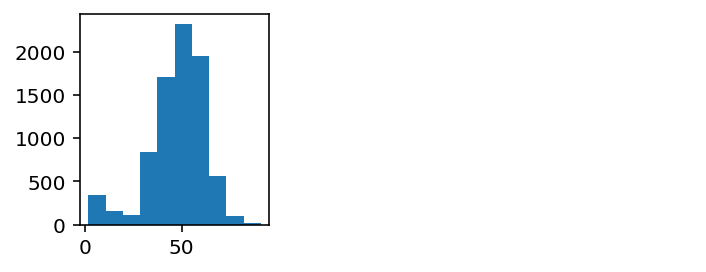

137. newrlbm


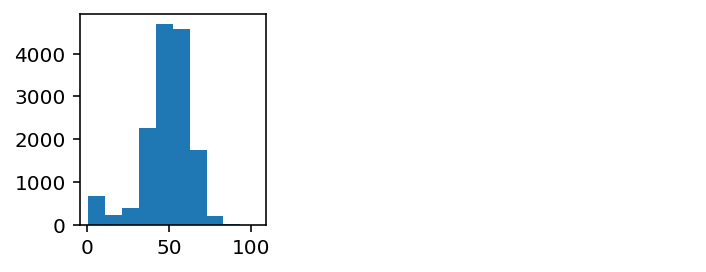

138. newlbmratio


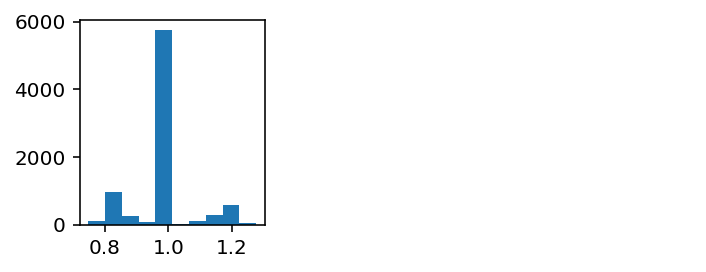

139. dcmass


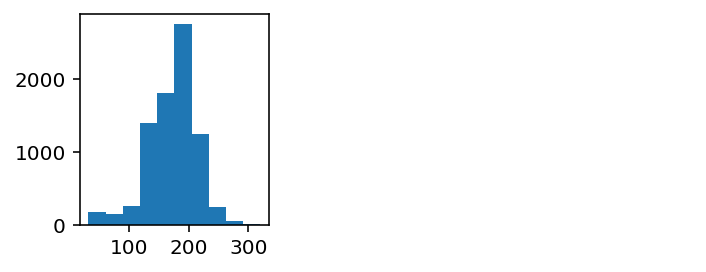

140. rcmass


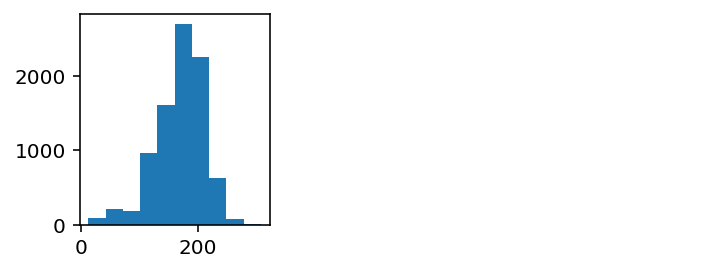

141. Heart mass ratio (log_cmassratio)


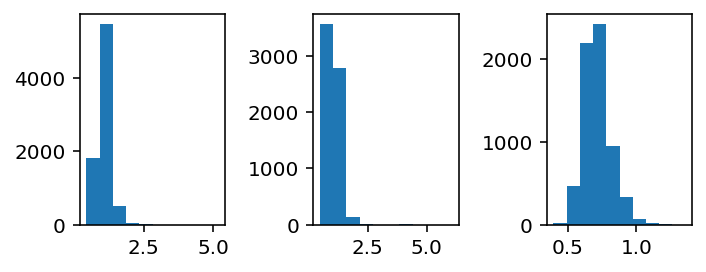

142. Sex match (sexmatch)


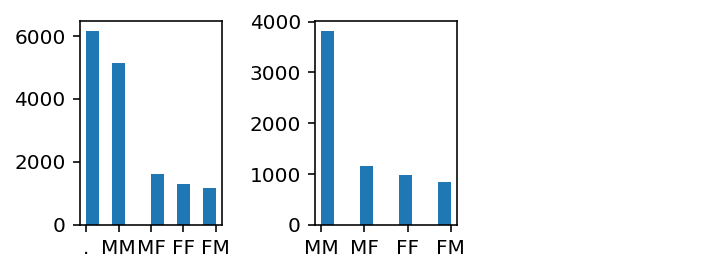

143. Any ECMO support (anyecmo)


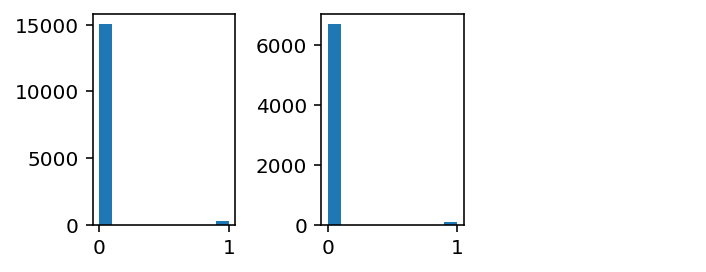

144. PVR (pvr)


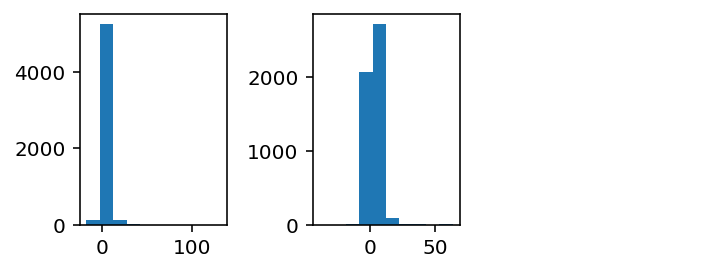

145. Any ventilation support (anyvent)


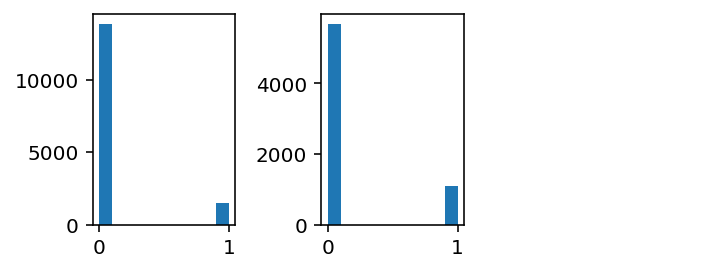

146. tx_date


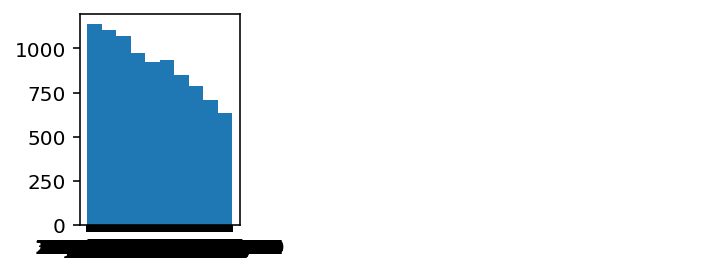

147. admission_date


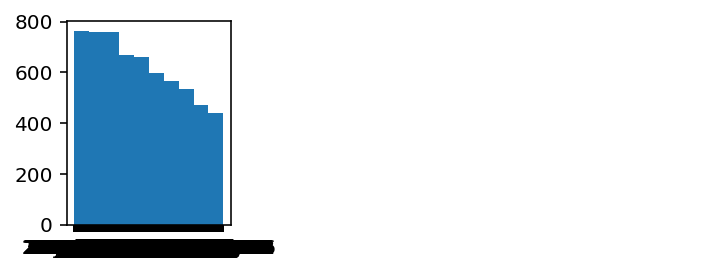


time: 9min 14s (started: 2021-03-27 10:44:47 +00:00)


In [37]:
from notebooks.heart_transplant.dependencies.heart_transplant_metadata import heart_transplant_metadata as metadata
from matplotlib import pyplot

X_365_reverse_log = reverse_log_transform_dataset(X_365)

for index, (feature_name, series) in enumerate(dataset_raw.items()):

    fig, ax = pyplot.subplots(1, 3, figsize=(5, 2))

    try:
        series.sample(frac=0.1).hist(grid=False, ax=ax[0])
    except Exception as e:
        print(e)

    log_feature_name = f'log_{feature_name}'

    try:
        X_365_reverse_log[feature_name]
    except KeyError:
        ax[1].axis("off")
    else:
        X_365_reverse_log[feature_name].loc[X_365.index].sample(frac=0.1).hist(
            grid=False, ax=ax[1]
        )

    try:
        X_365[log_feature_name]
    except KeyError:
        ax[2].axis("off")
    else:
        X_365[log_feature_name].loc[X_365.index].sample(frac=0.1).hist(
            grid=False, ax=ax[2]
        )

    metadata_item = metadata.get(feature_name)

    if log_feature_name in X_365:
        target_feature_name = log_feature_name
    else:
        target_feature_name = feature_name

    try:
        display_name = f'{metadata_item["name_long"]} ({target_feature_name})'
    except (KeyError, TypeError):
        display_name = f'{target_feature_name}'

    print(f'{index + 1}. {display_name}')
    fig.tight_layout()
    display(fig)
    pyplot.close()

print()